In [ ]:
!pip install tqdm

!apt-get update
!apt-get install -y wget

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,497 kB]
Ign:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,424 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,041 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,944

In [ ]:
!pip install selenium
!apt-get install -y chromium-browser
!apt-get install -y chromium-chromedriver

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup # For parsing HTML content
from urllib.parse import urljoin, urlparse # For handling URLs
import urllib.request # For making HTTP requests
import time # For handling time-related operations
import os # For interacting with the operating system (relate to dir, folder, file)
from tqdm import tqdm # For displaying progress bars (visualize progress)
import concurrent.futures # For multi-threading
import json # For writing to a text file
from PIL import Image # For handling images

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse3-3 liblzo2-2 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 snapd squashfs-tools systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 8 newly installed, 0 to remove and 46 not upgraded.
Need to get 28.4 MB of archives.
After this operation, 117 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubunt

In [ ]:
import os
import time
import json
from urllib.parse import urljoin
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from tqdm import tqdm
import concurrent.futures

class UrlScraper:
    def __init__(self, url_template, max_images=50, max_workers=4):
        self.url_template = url_template  # Liên kết crawl
        self.max_images = max_images  # Số ảnh tối đa
        self.max_workers = max_workers  # Số luồng
        self.setup_environment()  # Gọi hàm thiết lập môi trường

    # Thiết lập môi trường cho selenium
    def setup_environment(self):
        os.environ['PATH'] += ':/usr/lib/chromium-browser/'
        os.environ['PATH'] += ':/usr/lib/chromium-browser/chromedriver/'

    def get_url_images(self, term):
        """
        Crawl the urls of images by term

        Parameters:
        term (str): The name of animal, plant, scenery, furniture

        Returns:
        urls (list): List of urls of images
        """
        options = webdriver.ChromeOptions()
        options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        driver = webdriver.Chrome(options=options)
        url = self.url_template.format(search_term=term)
        driver.get(url)
        urls = []
        more_content_available = True

        pbar = tqdm(total=self.max_images, desc=f"Fetching images for {term}")
        while len(urls) < self.max_images and more_content_available:
            soup = BeautifulSoup(driver.page_source, "html.parser")
            img_tags = soup.find_all("img")
            for img in img_tags:
                if len(urls) >= self.max_images:
                    break
                if 'src' in img.attrs:
                    href = img.attrs['src']
                    img_path = urljoin(url, href)
                    img_path = img_path.replace("_m.jpg", "_b.jpg").replace("_n.jpg", "_b.jpg").replace("_w.jpg", "_b.jpg")

                    if img_path == "https://combo.staticflickr.com/ap/build/images/getty/IStock_corporate_logo.svg":
                        continue
                    urls.append(img_path)
                    pbar.update(1)
            try:
                load_more_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, '//button[@id="yui_3_16_0_1_1721642285931_28620"]'))
                )
                load_more_button.click()
                time.sleep(2)
            except Exception as e:
                print(f"Load more button not found or other issue: {e}")
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                new_soup = BeautifulSoup(driver.page_source, "html.parser")
                new_img_tags = new_soup.find_all("img", loading_="lazy")
                if len(new_img_tags) == len(img_tags):
                    more_content_available = False
                img_tags = new_img_tags
        pbar.close()
        driver.quit()
        return urls

    def scrape_urls(self, categories):
        """
        Call get_url_images method to get all urls of any object in categories

        Parameters:
        categories (dict): The dict of all object we need to collect image with format
                           categories{"name_object": [value1, value2, ...]}

        Returns:
        all_urls (dict): Dictionary of urls of images
        """
        all_urls = {category: {} for category in categories}

        # Handle multi-threading for efficient installation
        with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_term = {executor.submit(self.get_url_images, term): (category, term)
                              for category, terms in categories.items() for term in terms}

            for future in tqdm(concurrent.futures.as_completed(future_to_term), total=len(future_to_term), desc="Overall Progress"):
                category, term = future_to_term[future]
                try:
                    urls = future.result()
                    all_urls[category][term] = urls
                    print(f"\nNumber of images retrieved for {term}: {len(urls)}")
                except Exception as exc:
                    print(f"\n{term} generated an exception: {exc}")
        return all_urls

    def save_to_file(self, data, filename):
        """
        Save the data to a JSON file.

        Parameters:
        data (dict): The data to be saved.
        filename (str): The name of the JSON file.

        Returns:
        None
        """
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)
        print(f"Data saved to {filename}")


In [ ]:
def scrape_urls(self, categories):
  all_urls = {category: {} for category in categories}

# Handle multi-threading for efficent installation
  with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
     future_to_term = {executor.submit(self.get_url_images, term): (category, term)
                    for category, terms in categories.items() for term in terms}

     for future in tqdm(concurrent.futures.as_completed(future_to_term), total=len(future_to_term), desc="Overall Progress"):
         category, term = future_to_term[future]
         try:
           urls = future.result()
           all_urls[category][term] = urls
           print(f"\nNumber of images retrieved for {term}: {len(urls)}")
         except Exception as exc:
          print(f"\n{term} generated an exception: {exc}")
  return all_urls

In [ ]:
categories = {
  "animal": ["Monkey", "Elephant", "cows", "Cat", "Dog", "bear", "fox", "Civet", "Pangolins"
             ,"Rabbit", "Bats", "Whale", "Cock", "Owl", "flamingo", "Lizard", "Turtle", "Snake", "Frog", "Fish", "shrimp", "Crab", "Snail", "Coral", "Jellyfish", "Butterfly", "Flies",
             "Mosquito", "Ants", "Cockroaches", "Spider", "scorpion", "tiger", "bird", "horse", "pig", "Alligator", "Alpaca", "Anteater", "donkey", "Bee", "Buffalo", "Camel", "Caterpillar", "Cheetah", "Chicken", "Dragonfly", "Duck", "panda", "Giraffe"],

  "plant": ["Bamboo", "Apple", "Apricot", "Banana", "Bean", "Wildflower", "Flower", "Mushroom", "Weed", "Fern", "Reed", "Shrub", "Moss", "Grass", "Palmtree", "Corn", "Tulip", "Rose", "Clove", "Dogwood", "Durian", "Ferns", "Fig", "Flax", "Frangipani", "Lantana", "Hibiscus", "Bougainvillea", "Pea", "OrchidTree", "RangoonCreeper", "Jackfruit", "Cottonplant", "Corneliantree", "Coffeeplant", "Coconut", "wheat", "watermelon", "radish", "carrot"],

  "furniture": ["bed", "cabinet", "chair", "chests", "clock", "desks", "table", "Piano", "Bookcase", "Umbrella", "Clothes", "cart", "sofa", "ball", "spoon", "Bowl", "fridge", "pan", "book"],

  "scenery": ["Cliff", "Bay", "Coast", "Mountains", "Forests", "Waterbodies", "Lake", "desert", "farmland", "river", "hedges", "plain", "sky", "cave", "cloud", "flowergarden"
              ,"glacier", "grassland", "horizon", "lighthouse", "plateau", "savannah", "valley", "volcano", "waterfall"]

}

urltopic = {"flickr": "https://www.flickr.com/search/?text={search_term}"}
scraper = UrlScraper(url_template=urltopic["flickr"], max_images=20, max_workers=5)
image_urls = scraper.scrape_urls(categories)
scraper.save_to_file(image_urls, 'image_urls.json')

Overall Progress:   1%|▏         | 2/134 [00:46<42:10, 19.17s/it]  


Elephant generated an exception: Message: session not created: Chrome failed to start: exited normally.
  (session not created: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /root/.cache/selenium/chrome/linux64/127.0.6533.119/chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)
Stacktrace:
#0 0x5b0b55c966ca <unknown>
#1 0x5b0b55967600 <unknown>
#2 0x5b0b5599f485 <unknown>
#3 0x5b0b5599b2f8 <unknown>
#4 0x5b0b559e5ce8 <unknown>
#5 0x5b0b559d9643 <unknown>
#6 0x5b0b559a9d31 <unknown>
#7 0x5b0b559aa79e <unknown>
#8 0x5b0b55c5e25b <unknown>
#9 0x5b0b55c621f2 <unknown>
#10 0x5b0b55c4b615 <unknown>
#11 0x5b0b55c62d82 <unknown>
#12 0x5b0b55c3025f <unknown>
#13 0x5b0b55c85e68 <unknown>
#14 0x5b0b55c86040 <unknown>
#15 0x5b0b55c9549c <unknown>
#16 0x7f0780a4bac3 <unknown>


Monkey generated an exception: Message: session not created: Chrome failed to start: exited normally.
  (session not created: DevToolsActivePort file doesn'


Fetching images for fox:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Dog:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Civet:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for cows:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Cat:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for cows:   5%|▌         | 1/20 [00:03<00:59,  3.11s/it]



Fetching images for cows:  10%|█         | 2/20 [00:03<00:25,  1.43s/it]



Fetching images for cows:  15%|█▌        | 3/20 [00:03<00:14,  1.17it/s]




Fetching images for Cat:   5%|▌         | 1/20 [00:03<00:58,  3.10s/it]




Fetching images for Cat:  10%|█         | 2/20 [00:03<00:26,  1.46s/it]




Fetching images for Cat:  15%|█▌        | 3/20 [00:03<00:14,  1.18it/s]




Fetching images for Cat:  20%|██        | 4/20 [00:03<00:09,  1.67it/s]




Fetching images for fox:  10%|█         | 2/20 [00:07<00:54,  3.01s/it]


Fetching images for Civet:   5%|▌         | 1/20 [00:05<

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58d6efe0e6ca <unknown>
#1 0x58d6efadf600 <unknown>
#2 0x58d6efb2ebcb <unknown>
#3 0x58d6efb2eeb1 <unknown>
#4 0x58d6efb72b24 <unknown>
#5 0x58d6efb518cd <unknown>
#6 0x58d6efb7004a <unknown>
#7 0x58d6efb51643 <unknown>
#8 0x58d6efb21d31 <unknown>
#9 0x58d6efb2279e <unknown>
#10 0x58d6efdd625b <unknown>
#11 0x58d6efdda1f2 <unknown>
#12 0x58d6efdc3615 <unknown>
#13 0x58d6efddad82 <unknown>
#14 0x58d6efda825f <unknown>
#15 0x58d6efdfde68 <unknown>
#16 0x58d6efdfe040 <unknown>
#17 0x58d6efe0d49c <unknown>
#18 0x784df4a87ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c9ecc8996ca <unknown>
#1 0x5c9ecc56a600 <unknown>
#2 0x5c9ecc5b9bcb <unknown>
#3 0x5c9ecc5b9eb1 <unknown>
#4 0x5c9ecc5fdb24 <unknown>
#5 0x5c9ecc5dc8cd <unknown>
#6 0x5c9ecc5fb04a <unknown>
#7 0x5c9ecc5dc643 <unknown>
#8 0x5c9ecc5acd31 <unknown>
#9 0x5c9ecc5ad79e <unknown>
#10 0x5c9ecc86125b <unknown>
#11 0x5c9ecc8651f2 

Overall Progress:   3%|▎         | 4/134 [01:29<44:30, 20.54s/it]


Number of images retrieved for cows: 20


Overall Progress:   4%|▎         | 5/134 [01:31<31:41, 14.74s/it]


Number of images retrieved for Cat: 20


Fetching images for Civet: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Number of images retrieved for fox: 20



Overall Progress:   5%|▌         | 7/134 [01:32<15:43,  7.43s/it]


Number of images retrieved for Civet: 20


Overall Progress:   6%|▌         | 8/134 [01:32<11:03,  5.27s/it]


Number of images retrieved for Dog: 20



Fetching images for Pangolins:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Rabbit:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Bats:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Rabbit:   5%|▌         | 1/20 [00:01<00:35,  1.87s/it]


Fetching images for Bats:   5%|▌         | 1/20 [00:01<00:26,  1.40s/it]



Fetching images for Whale:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Cock:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Whale:   5%|▌         | 1/20 [00:04<01:17,  4.07s/it]



Fetching images for Pangolins:   5%|▌         | 1/20 [00:06<02:10,  6.88s/it]




Fetching images for Cock:   5%|▌         | 1/20 [00:04<01:18,  4.15s/it]




Fetching images for Cock:  10%|█         | 2/20 [00:04<00:31,  1.77s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55fa3dfba6ca <unknown>
#1 0x55fa3dc8b600 <unknown>
#2 0x55fa3dcdabcb <unknown>
#3 0x55fa3dcdaeb1 <unknown>
#4 0x55fa3dd1eb24 <unknown>
#5 0x55fa3dcfd8cd <unknown>
#6 0x55fa3dd1c04a <unknown>
#7 0x55fa3dcfd643 <unknown>
#8 0x55fa3dccdd31 <unknown>
#9 0x55fa3dcce79e <unknown>
#10 0x55fa3df8225b <unknown>
#11 0x55fa3df861f2 <unknown>
#12 0x55fa3df6f615 <unknown>
#13 0x55fa3df86d82 <unknown>
#14 0x55fa3df5425f <unknown>
#15 0x55fa3dfa9e68 <unknown>
#16 0x55fa3dfaa040 <unknown>
#17 0x55fa3dfb949c <unknown>
#18 0x7d19ee898ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58e132cd06ca <unknown>
#1 0x58e1329a1600 <unknown>
#2 0x58e1329f0bcb <unknown>
#3 0x58e1329f0eb1 <unknown>
#4 0x58e132a34b24 <unknown>
#5 0x58e132a138cd <unknown>
#6 0x58e132a3204a <unknown>
#7 0x58e132a13643 <unknown>
#8 0x58e1329e3d31 <unknown>
#9 0x58e1329e479e <unknown>
#10 0x58e132c9825b <unknown>
#11 0x58e132c9c1f2 

Fetching images for Bats: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]



Number of images retrieved for Rabbit: 20


Overall Progress:   7%|▋         | 10/134 [02:12<22:52, 11.07s/it]


Number of images retrieved for Bats: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5bab71c3a6ca <unknown>
#1 0x5bab7190b600 <unknown>
#2 0x5bab7195abcb <unknown>
#3 0x5bab7195aeb1 <unknown>
#4 0x5bab7199eb24 <unknown>
#5 0x5bab7197d8cd <unknown>
#6 0x5bab7199c04a <unknown>
#7 0x5bab7197d643 <unknown>
#8 0x5bab7194dd31 <unknown>
#9 0x5bab7194e79e <unknown>
#10 0x5bab71c0225b <unknown>
#11 0x5bab71c061f2 <unknown>
#12 0x5bab71bef615 <unknown>
#13 0x5bab71c06d82 <unknown>
#14 0x5bab71bd425f <unknown>
#15 0x5bab71c29e68 <unknown>
#16 0x5bab71c2a040 <unknown>
#17 0x5bab71c3949c <unknown>
#18 0x7e9e9eb53ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56230a0af6ca <unknown>
#1 0x562309d80600 <unknown>
#2 0x562309dcfbcb <unknown>
#3 0x562309dcfeb1 <unknown>
#4 0x562309e13b24 <unknown>
#5 0x562309df28cd <unknown>
#6 0x562309e1104a <unknown>
#7 0x562309df2643 <unknown>
#8 0x562309dc2d31 <unknown>
#9 0x562309dc379e <unknown>
#10 0x5

Fetching images for Cock: 100%|██████████| 20/20 [00:22<00:00,  1.15s/it]


Number of images retrieved for Pangolins: 20



Overall Progress:  10%|▉         | 13/134 [02:22<10:36,  5.26s/it]


Number of images retrieved for Cock: 20

Number of images retrieved for Whale: 20



Fetching images for Owl:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Owl:   5%|▌         | 1/20 [00:06<02:03,  6.49s/it]

Fetching images for flamingo:   5%|▌         | 1/20 [00:06<02:07,  6.72s/it]


Fetching images for Lizard:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Snake:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Turtle:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Lizard:   5%|▌         | 1/20 [00:05<01:50,  5.81s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b6c39a136ca <unknown>
#1 0x5b6c396e4600 <unknown>
#2 0x5b6c39733bcb <unknown>
#3 0x5b6c39733eb1 <unknown>
#4 0x5b6c39777b24 <unknown>
#5 0x5b6c397568cd <unknown>
#6 0x5b6c3977504a <unknown>
#7 0x5b6c39756643 <unknown>
#8 0x5b6c39726d31 <unknown>
#9 0x5b6c3972779e <unknown>
#10 0x5b6c399db25b <unknown>
#11 0x5b6c399df1f2 <unknown>
#12 0x5b6c399c8615 <unknown>
#13 0x5b6c399dfd82 <unknown>
#14 0x5b6c399ad25f <unknown>
#15 0x5b6c39a02e68 <unknown>
#16 0x5b6c39a03040 <unknown>
#17 0x5b6c39a1249c <unknown>
#18 0x7e176d035ac3 <unknown>








Fetching images for Turtle:   5%|▌         | 1/20 [00:07<02:19,  7.33s/it]



Fetching images for Snake:   5%|▌         | 1/20 [00:08<02:39,  8.38s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5ba15de8f6ca <unknown>
#1 0x5ba15db60600 <unknown>
#2 0x5ba15dbafbcb <unknown>
#3 0x5ba15dbafeb1 <unknown>
#4 0x5ba15dbf3b24 <unknown>
#5 0x5ba15dbd28cd <unknown>
#6 0x5ba15dbf104a <unknown>
#7 0x5ba15dbd2643 <unknown>
#8 0x5ba15dba2d31 <unknown>
#9 0x5ba15dba379e <unknown>
#10 0x5ba15de5725b <unknown>
#11 0x5ba15de5b1f2 <unknown>
#12 0x5ba15de44615 <unknown>
#13 0x5ba15de5bd82 <unknown>
#14 0x5ba15de2925f <unknown>
#15 0x5ba15de7ee68 <unknown>
#16 0x5ba15de7f040 <unknown>
#17 0x5ba15de8e49c <unknown>
#18 0x7f175e0a6ac3 <unknown>



Overall Progress:  10%|█         | 14/134 [03:03<32:04, 16.04s/it]


Number of images retrieved for Owl: 20


Overall Progress:  11%|█         | 15/134 [03:05<23:16, 11.74s/it]


Number of images retrieved for flamingo: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a330d55e6ca <unknown>
#1 0x5a330d22f600 <unknown>
#2 0x5a330d27ebcb <unknown>
#3 0x5a330d27eeb1 <unknown>
#4 0x5a330d2c2b24 <unknown>
#5 0x5a330d2a18cd <unknown>
#6 0x5a330d2c004a <unknown>
#7 0x5a330d2a1643 <unknown>
#8 0x5a330d271d31 <unknown>
#9 0x5a330d27279e <unknown>
#10 0x5a330d52625b <unknown>
#11 0x5a330d52a1f2 <unknown>
#12 0x5a330d513615 <unknown>
#13 0x5a330d52ad82 <unknown>
#14 0x5a330d4f825f <unknown>
#15 0x5a330d54de68 <unknown>
#16 0x5a330d54e040 <unknown>
#17 0x5a330d55d49c <unknown>
#18 0x7aed1fdbaac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b7c68dff6ca <unknown>
#1 0x5b7c68ad0600 <unknown>
#2 0x5b7c68b1fbcb <unknown>
#3 0x5b7c68b1feb1 <unknown>
#4 0x5b7c68b63b24 <unknown>
#5 0x5b7c68b428cd <unknown>
#6 0x5b7c68b6104a <unknown>
#7 0x5b7c68b42643 <unknown>
#8 0x5b7c68b12d31 <unknown>
#9 0x5b7c68b1379e <unknown>
#10

Fetching images for Turtle: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


Number of images retrieved for Lizard: 20



Overall Progress:  13%|█▎        | 17/134 [03:16<15:58,  8.19s/it]


Number of images retrieved for Turtle: 20


Overall Progress:  13%|█▎        | 18/134 [03:17<11:39,  6.03s/it]


Number of images retrieved for Snake: 20



Fetching images for Frog:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Frog:   5%|▌         | 1/20 [00:02<00:44,  2.32s/it]

Fetching images for Fish:   5%|▌         | 1/20 [00:01<00:24,  1.26s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5997477916ca <unknown>
#1 0x599747462600 <unknown>
#2 0x5997474b1bcb <unknown>
#3 0x5997474b1eb1 <unknown>
#4 0x5997474f5b24 <unknown>
#5 0x5997474d48cd <unknown>
#6 0x5997474f304a <unknown>
#7 0x5997474d4643 <unknown>
#8 0x5997474a4d31 <unknown>
#9 0x5997474a579e <unknown>
#10 0x59974775925b <unknown>
#11 0x59974775d1f2 <unknown>
#12 0x599747746615 <unknown>
#13 0x59974775dd82 <unknown>
#14 0x59974772b25f <unknown>
#15 0x599747780e68 <unknown>
#16 0x599747781040 <unknown>
#17 0x59974779049c <unknown>
#18 0x7882a8a75ac3 <unknown>






Fetching images for shrimp:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Snail:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Crab:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b30567dc6ca <unknown>
#1 0x5b30564ad600 <unknown>
#2 0x5b30564fcbcb <unknown>
#3 0x5b30564fceb1 <unknown>
#4 0x5b3056540b24 <unknown>
#5 0x5b305651f8cd <unknown>
#6 0x5b305653e04a <unknown>
#7 0x5b305651f643 <unknown>
#8 0x5b30564efd31 <unknown>
#9 0x5b30564f079e <unknown>
#10 0x5b30567a425b <unknown>
#11 0x5b30567a81f2 <unknown>
#12 0x5b3056791615 <unknown>
#13 0x5b30567a8d82 <unknown>
#14 0x5b305677625f <unknown>
#15 0x5b30567cbe68 <unknown>
#16 0x5b30567cc040 <unknown>
#17 0x5b30567db49c <unknown>
#18 0x7dca90354ac3 <unknown>






Fetching images for shrimp:   5%|▌         | 1/20 [00:02<00:48,  2.57s/it]



Fetching images for Snail:   5%|▌         | 1/20 [00:05<01:37,  5.14s/it]




Overall Progress:  14%|█▍        | 19/134 [03:46<24:27, 12.76s/it]


Number of images retrieved for Frog: 20


Overall Progress:  15%|█▍        | 20/134 [03:50<19:10, 10.09s/it]


Number of images retrieved for Fish: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57d6b3adc6ca <unknown>
#1 0x57d6b37ad600 <unknown>
#2 0x57d6b37fcbcb <unknown>
#3 0x57d6b37fceb1 <unknown>
#4 0x57d6b3840b24 <unknown>
#5 0x57d6b381f8cd <unknown>
#6 0x57d6b383e04a <unknown>
#7 0x57d6b381f643 <unknown>
#8 0x57d6b37efd31 <unknown>
#9 0x57d6b37f079e <unknown>
#10 0x57d6b3aa425b <unknown>
#11 0x57d6b3aa81f2 <unknown>
#12 0x57d6b3a91615 <unknown>
#13 0x57d6b3aa8d82 <unknown>
#14 0x57d6b3a7625f <unknown>
#15 0x57d6b3acbe68 <unknown>
#16 0x57d6b3acc040 <unknown>
#17 0x57d6b3adb49c <unknown>
#18 0x7f6537311ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c1ef30b16ca <unknown>
#1 0x5c1ef2d82600 <unknown>
#2 0x5c1ef2dd1bcb <unknown>
#3 0x5c1ef2dd1eb1 <unknown>
#4 0x5c1ef2e15b24 <unknown>
#5 0x5c1ef2df48cd <unknown>
#6 0x5c1ef2e1304a <unknown>
#7 0x5c1ef2df4643 <unknown>
#8 0x5c1ef2dc4d31 <unknown>
#9 0x5c1ef2dc579e <unknown>
#10 0x5

Overall Progress:  16%|█▌        | 21/134 [04:00<19:06, 10.15s/it]


Number of images retrieved for shrimp: 20


Overall Progress:  16%|█▋        | 22/134 [04:01<13:58,  7.49s/it]


Number of images retrieved for Crab: 20


Fetching images for Snail: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]

Overall Progress:  17%|█▋        | 23/134 [04:02<10:01,  5.42s/it]


Number of images retrieved for Snail: 20



Fetching images for Coral:   5%|▌         | 1/20 [00:01<00:36,  1.90s/it]

Fetching images for Jellyfish:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Jellyfish:   5%|▌         | 1/20 [00:02<00:50,  2.67s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59e5ad1026ca <unknown>
#1 0x59e5acdd3600 <unknown>
#2 0x59e5ace22bcb <unknown>
#3 0x59e5ace22eb1 <unknown>
#4 0x59e5ace66b24 <unknown>
#5 0x59e5ace458cd <unknown>
#6 0x59e5ace6404a <unknown>
#7 0x59e5ace45643 <unknown>
#8 0x59e5ace15d31 <unknown>
#9 0x59e5ace1679e <unknown>
#10 0x59e5ad0ca25b <unknown>
#11 0x59e5ad0ce1f2 <unknown>
#12 0x59e5ad0b7615 <unknown>
#13 0x59e5ad0ced82 <unknown>
#14 0x59e5ad09c25f <unknown>
#15 0x59e5ad0f1e68 <unknown>
#16 0x59e5ad0f2040 <unknown>
#17 0x59e5ad10149c <unknown>
#18 0x7b368733aac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5cdd314596ca <unknown>
#1 0x5cdd3112a600 <unknown>
#2 0x5cdd31179bcb <unknown>
#3 0x5cdd31179eb1 <unknown>
#4 0x5cdd311bdb24 <unknown>
#5 0x5cdd3119c8cd <unknown>
#6 0x5cdd311bb04a <unknown>
#7 0x5cdd3119c643 <unknown>
#8 0x5cdd3116cd31 <unknown>
#9 0x5cdd3116d79e <unknown>
#10 0x5cdd3142125b <unknown>
#11 0x5cdd314251f2 




Fetching images for Butterfly:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  18%|█▊        | 24/134 [04:26<20:34, 11.22s/it]


Number of images retrieved for Coral: 20



Fetching images for Mosquito:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Butterfly:   5%|▌         | 1/20 [00:06<02:08,  6.77s/it]



Overall Progress:  19%|█▊        | 25/134 [04:33<17:48,  9.80s/it]


Number of images retrieved for Jellyfish: 20



Fetching images for Mosquito:   5%|▌         | 1/20 [00:03<01:02,  3.28s/it]

Fetching images for Cockroaches:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Cockroaches:   5%|▌         | 1/20 [00:00<00:07,  2.38it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56c24b3266ca <unknown>
#1 0x56c24aff7600 <unknown>
#2 0x56c24b046bcb <unknown>
#3 0x56c24b046eb1 <unknown>
#4 0x56c24b08ab24 <unknown>
#5 0x56c24b0698cd <unknown>
#6 0x56c24b08804a <unknown>
#7 0x56c24b069643 <unknown>
#8 0x56c24b039d31 <unknown>
#9 0x56c24b03a79e <unknown>
#10 0x56c24b2ee25b <unknown>
#11 0x56c24b2f21f2 <unknown>
#12 0x56c24b2db615 <unknown>
#13 0x56c24b2f2d82 <unknown>
#14 0x56c24b2c025f <unknown>
#15 0x56c24b315e68 <unknown>
#16 0x56c24b316040 <unknown>
#17 0x56c24b32549c <unknown>
#18 0x7f78bdf32ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a9857d336ca <unknown>
#1 0x5a9857a04600 <unknown>
#2 0x5a9857a53bcb <unknown>
#3 0x5a9857a53eb1 <unknown>
#4 0x5a9857a97b24 <unknown>
#5 0x5a9857a768cd <unknown>
#6 0x5a9857a9504a <unknown>
#7 0x5a9857a76643 <unknown>
#8 0x5a9857a46d31 <unknown>
#9 0x5a9857a4779e <unknown>
#10 0x5a9857cfb25b <unknown>
#11 0x5a9857cff1f2 

Overall Progress:  19%|█▉        | 26/134 [04:49<21:12, 11.78s/it]


Number of images retrieved for Butterfly: 20


Overall Progress:  20%|██        | 27/134 [04:51<15:19,  8.59s/it]


Number of images retrieved for Flies: 20


Overall Progress:  21%|██        | 28/134 [04:52<11:20,  6.42s/it]


Number of images retrieved for Mosquito: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x575bdfd486ca <unknown>
#1 0x575bdfa19600 <unknown>
#2 0x575bdfa68bcb <unknown>
#3 0x575bdfa68eb1 <unknown>
#4 0x575bdfaacb24 <unknown>
#5 0x575bdfa8b8cd <unknown>
#6 0x575bdfaaa04a <unknown>
#7 0x575bdfa8b643 <unknown>
#8 0x575bdfa5bd31 <unknown>
#9 0x575bdfa5c79e <unknown>
#10 0x575bdfd1025b <unknown>
#11 0x575bdfd141f2 <unknown>
#12 0x575bdfcfd615 <unknown>
#13 0x575bdfd14d82 <unknown>
#14 0x575bdfce225f <unknown>
#15 0x575bdfd37e68 <unknown>
#16 0x575bdfd38040 <unknown>
#17 0x575bdfd4749c <unknown>
#18 0x7822b13faac3 <unknown>



Overall Progress:  22%|██▏       | 29/134 [05:01<12:47,  7.31s/it]


Number of images retrieved for Cockroaches: 20



Fetching images for scorpion:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for tiger:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for scorpion:   5%|▌         | 1/20 [00:02<00:45,  2.39s/it]


Fetching images for Spider:   5%|▌         | 1/20 [00:01<00:23,  1.25s/it]

Fetching images for tiger:   5%|▌         | 1/20 [00:02<00:46,  2.43s/it]



Fetching images for bird:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for bird:   5%|▌         | 1/20 [00:03<01:00,  3.16s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5aa132cc26ca <unknown>
#1 0x5aa132993600 <unknown>
#2 0x5aa1329e2bcb <unknown>
#3 0x5aa1329e2eb1 <unknown>
#4 0x5aa132a26b24 <unknown>
#5 0x5aa132a058cd <unknown>
#6 0x5aa132a2404a <unknown>
#7 0x5aa132a05643 <unknown>
#8 0x5aa1329d5d31 <unknown>
#9 0x5aa1329d679e <unknown>
#10 0x5aa132c8a25b <unknown>
#11 0x5aa132c8e1f2 <unknown>
#12 0x5aa132c77615 <unknown>
#13 0x5aa132c8ed82 <unknown>
#14 0x5aa132c5c25f <unknown>
#15 0x5aa132cb1e68 <unknown>
#16 0x5aa132cb2040 <unknown>
#17 0x5aa132cc149c <unknown>
#18 0x7e47eea67ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x566d9b7d76ca <unknown>
#1 0x566d9b4a8600 <unknown>
#2 0x566d9b4f7bcb <unknown>
#3 0x566d9b4f7eb1 <unknown>
#4 0x566d9b53bb24 <unknown>
#5 0x566d9b51a8cd <unknown>
#6 0x566d9b53904a <unknown>
#7 0x566d9b51a643 <unknown>
#8 0x566d9b4ead31 <unknown>
#9 0x566d9b4eb79e <unknown>
#10 0x566d9b79f25b <unknown>
#11 0x566d9b7a31f2 

Overall Progress:  23%|██▎       | 31/134 [05:30<16:31,  9.63s/it]


Number of images retrieved for scorpion: 20

Number of images retrieved for Spider: 20


Overall Progress:  24%|██▍       | 32/134 [05:31<11:46,  6.93s/it]


Number of images retrieved for tiger: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5afe2c67f6ca <unknown>
#1 0x5afe2c350600 <unknown>
#2 0x5afe2c39fbcb <unknown>
#3 0x5afe2c39feb1 <unknown>
#4 0x5afe2c3e3b24 <unknown>
#5 0x5afe2c3c28cd <unknown>
#6 0x5afe2c3e104a <unknown>
#7 0x5afe2c3c2643 <unknown>
#8 0x5afe2c392d31 <unknown>
#9 0x5afe2c39379e <unknown>
#10 0x5afe2c64725b <unknown>
#11 0x5afe2c64b1f2 <unknown>
#12 0x5afe2c634615 <unknown>
#13 0x5afe2c64bd82 <unknown>
#14 0x5afe2c61925f <unknown>
#15 0x5afe2c66ee68 <unknown>
#16 0x5afe2c66f040 <unknown>
#17 0x5afe2c67e49c <unknown>
#18 0x790d4111aac3 <unknown>



Overall Progress:  25%|██▍       | 33/134 [05:41<13:36,  8.08s/it]


Number of images retrieved for bird: 20



Fetching images for horse:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Alligator:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for horse:   5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

Fetching images for Alligator:   5%|▌         | 1/20 [00:01<00:21,  1.12s/it]


Fetching images for pig:   5%|▌         | 1/20 [00:01<00:29,  1.53s/it]



Fetching images for Alpaca:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5af2375c86ca <unknown>
#1 0x5af237299600 <unknown>
#2 0x5af2372e8bcb <unknown>
#3 0x5af2372e8eb1 <unknown>
#4 0x5af23732cb24 <unknown>
#5 0x5af23730b8cd <unknown>
#6 0x5af23732a04a <unknown>
#7 0x5af23730b643 <unknown>
#8 0x5af2372dbd31 <unknown>
#9 0x5af2372dc79e <unknown>
#10 0x5af23759025b <unknown>
#11 0x5af2375941f2 <unknown>
#12 0x5af23757d615 <unknown>
#13 0x5af237594d82 <unknown>
#14 0x5af23756225f <unknown>
#15 0x5af2375b7e68 <unknown>
#16 0x5af2375b8040 <unknown>
#17 0x5af2375c749c <unknown>
#18 0x77fd32435ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59bf35a806ca <unknown>
#1 0x59bf35751600 <unknown>
#2 0x59bf357a0bcb <unknown>
#3 0x59bf357a0eb1 <unknown>
#4 0x59bf357e4b24 <unknown>
#5 0x59bf357c38cd <unknown>
#6 0x59bf357e204a <unknown>
#7 0x59bf357c3643 <unknown>
#8 0x59bf35793d31 <unknown>
#9 0x59bf3579479e <unknown>
#10 0x59bf35a4825b <unknown>
#11 0x59bf35a4c1f2 





Overall Progress:  25%|██▌       | 34/134 [06:10<23:45, 14.26s/it]


Number of images retrieved for horse: 20


Overall Progress:  26%|██▌       | 35/134 [06:11<16:43, 10.14s/it]


Number of images retrieved for pig: 20


Overall Progress:  27%|██▋       | 36/134 [06:11<11:56,  7.31s/it]


Number of images retrieved for Alligator: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58fe4dcf66ca <unknown>
#1 0x58fe4d9c7600 <unknown>
#2 0x58fe4da16bcb <unknown>
#3 0x58fe4da16eb1 <unknown>
#4 0x58fe4da5ab24 <unknown>
#5 0x58fe4da398cd <unknown>
#6 0x58fe4da5804a <unknown>
#7 0x58fe4da39643 <unknown>
#8 0x58fe4da09d31 <unknown>
#9 0x58fe4da0a79e <unknown>
#10 0x58fe4dcbe25b <unknown>
#11 0x58fe4dcc21f2 <unknown>
#12 0x58fe4dcab615 <unknown>
#13 0x58fe4dcc2d82 <unknown>
#14 0x58fe4dc9025f <unknown>
#15 0x58fe4dce5e68 <unknown>
#16 0x58fe4dce6040 <unknown>
#17 0x58fe4dcf549c <unknown>
#18 0x79fc3b55eac3 <unknown>



Overall Progress:  28%|██▊       | 37/134 [06:26<15:17,  9.45s/it]


Number of images retrieved for Alpaca: 20



Fetching images for Anteater:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Bee:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Anteater:   5%|▌         | 1/20 [00:01<00:32,  1.73s/it]


Fetching images for donkey:   5%|▌         | 1/20 [00:02<00:38,  2.00s/it]

Fetching images for Bee:   5%|▌         | 1/20 [00:02<00:44,  2.33s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c57ffea36ca <unknown>
#1 0x5c57ffb74600 <unknown>
#2 0x5c57ffbc3bcb <unknown>
#3 0x5c57ffbc3eb1 <unknown>
#4 0x5c57ffc07b24 <unknown>
#5 0x5c57ffbe68cd <unknown>
#6 0x5c57ffc0504a <unknown>
#7 0x5c57ffbe6643 <unknown>
#8 0x5c57ffbb6d31 <unknown>
#9 0x5c57ffbb779e <unknown>
#10 0x5c57ffe6b25b <unknown>
#11 0x5c57ffe6f1f2 <unknown>
#12 0x5c57ffe58615 <unknown>
#13 0x5c57ffe6fd82 <unknown>
#14 0x5c57ffe3d25f <unknown>
#15 0x5c57ffe92e68 <unknown>
#16 0x5c57ffe93040 <unknown>
#17 0x5c57ffea249c <unknown>
#18 0x780c4285fac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5ac42dca26ca <unknown>
#1 0x5ac42d973600 <unknown>
#2 0x5ac42d9c2bcb <unknown>
#3 0x5ac42d9c2eb1 <unknown>
#4 0x5ac42da06b24 <unknown>
#5 0x5ac42d9e58cd <unknown>
#6 0x5ac42da0404a <unknown>
#7 0x5ac42d9e5643 <unknown>
#8 0x5ac42d9b5d31 <unknown>
#9 0x5ac42d9b679e <unknown>
#10 0x5ac42dc6a25b <unknown>
#11 0x5ac42dc6e1f2 





Fetching images for Buffalo:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  28%|██▊       | 38/134 [06:49<21:47, 13.62s/it]


Number of images retrieved for Anteater: 20


Overall Progress:  30%|██▉       | 40/134 [06:52<11:16,  7.20s/it]


Number of images retrieved for Bee: 20

Number of images retrieved for donkey: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58b3b29bb6ca <unknown>
#1 0x58b3b268c600 <unknown>
#2 0x58b3b26dbbcb <unknown>
#3 0x58b3b26dbeb1 <unknown>
#4 0x58b3b271fb24 <unknown>
#5 0x58b3b26fe8cd <unknown>
#6 0x58b3b271d04a <unknown>
#7 0x58b3b26fe643 <unknown>
#8 0x58b3b26ced31 <unknown>
#9 0x58b3b26cf79e <unknown>
#10 0x58b3b298325b <unknown>
#11 0x58b3b29871f2 <unknown>
#12 0x58b3b2970615 <unknown>
#13 0x58b3b2987d82 <unknown>
#14 0x58b3b295525f <unknown>
#15 0x58b3b29aae68 <unknown>
#16 0x58b3b29ab040 <unknown>
#17 0x58b3b29ba49c <unknown>
#18 0x7f21ae40aac3 <unknown>



Overall Progress:  31%|███       | 41/134 [07:04<13:32,  8.73s/it]


Number of images retrieved for Buffalo: 20



Fetching images for Camel:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Camel:   5%|▌         | 1/20 [00:01<00:27,  1.46s/it]


Fetching images for Caterpillar:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Caterpillar:   5%|▌         | 1/20 [00:01<00:20,  1.05s/it]

Fetching images for Cheetah:   5%|▌         | 1/20 [00:01<00:27,  1.46s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59ff5e0b26ca <unknown>
#1 0x59ff5dd83600 <unknown>
#2 0x59ff5ddd2bcb <unknown>
#3 0x59ff5ddd2eb1 <unknown>
#4 0x59ff5de16b24 <unknown>
#5 0x59ff5ddf58cd <unknown>
#6 0x59ff5de1404a <unknown>
#7 0x59ff5ddf5643 <unknown>
#8 0x59ff5ddc5d31 <unknown>
#9 0x59ff5ddc679e <unknown>
#10 0x59ff5e07a25b <unknown>
#11 0x59ff5e07e1f2 <unknown>
#12 0x59ff5e067615 <unknown>
#13 0x59ff5e07ed82 <unknown>
#14 0x59ff5e04c25f <unknown>
#15 0x59ff5e0a1e68 <unknown>
#16 0x59ff5e0a2040 <unknown>
#17 0x59ff5e0b149c <unknown>
#18 0x7abb2933dac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x575fa6d4c6ca <unknown>
#1 0x575fa6a1d600 <unknown>
#2 0x575fa6a6cbcb <unknown>
#3 0x575fa6a6ceb1 <unknown>
#4 0x575fa6ab0b24 <unknown>
#5 0x575fa6a8f8cd <unknown>
#6 0x575fa6aae04a <unknown>
#7 0x575fa6a8f643 <unknown>
#8 0x575fa6a5fd31 <unknown>
#9 0x575fa6a6079e <unknown>
#10 0x575fa6d1425b <unknown>
#11 0x575fa6d181f2 





Fetching images for Chicken:   0%|          | 0/20 [00:00<?, ?it/s]




Fetching images for Ants:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  31%|███▏      | 42/134 [07:28<20:41, 13.50s/it]


Number of images retrieved for Camel: 20


Fetching images for Caterpillar: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]





Overall Progress:  32%|███▏      | 43/134 [07:31<15:16, 10.08s/it]


Number of images retrieved for Caterpillar: 20


Overall Progress:  33%|███▎      | 44/134 [07:31<10:59,  7.33s/it]


Number of images retrieved for Cheetah: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5aed0c8f66ca <unknown>
#1 0x5aed0c5c7600 <unknown>
#2 0x5aed0c616bcb <unknown>
#3 0x5aed0c616eb1 <unknown>
#4 0x5aed0c65ab24 <unknown>
#5 0x5aed0c6398cd <unknown>
#6 0x5aed0c65804a <unknown>
#7 0x5aed0c639643 <unknown>
#8 0x5aed0c609d31 <unknown>
#9 0x5aed0c60a79e <unknown>
#10 0x5aed0c8be25b <unknown>
#11 0x5aed0c8c21f2 <unknown>
#12 0x5aed0c8ab615 <unknown>
#13 0x5aed0c8c2d82 <unknown>
#14 0x5aed0c89025f <unknown>
#15 0x5aed0c8e5e68 <unknown>
#16 0x5aed0c8e6040 <unknown>
#17 0x5aed0c8f549c <unknown>
#18 0x78b4d9a2bac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x586e8061a6ca <unknown>
#1 0x586e802eb600 <unknown>
#2 0x586e8033abcb <unknown>
#3 0x586e8033aeb1 <unknown>
#4 0x586e8037eb24 <unknown>
#5 0x586e8035d8cd <unknown>
#6 0x586e8037c04a <unknown>
#7 0x586e8035d643 <unknown>
#8 0x586e8032dd31 <unknown>
#9 0x586e8032e79e <unknown>
#10 

Overall Progress:  34%|███▎      | 45/134 [07:42<12:28,  8.42s/it]


Number of images retrieved for Chicken: 20


Overall Progress:  34%|███▍      | 46/134 [07:45<09:33,  6.52s/it]


Number of images retrieved for Ants: 20



Fetching images for Duck:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Dragonfly:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for panda:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Dragonfly:   5%|▌         | 1/20 [00:01<00:29,  1.56s/it]


Fetching images for Duck:   5%|▌         | 1/20 [00:03<01:09,  3.66s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b5a9478d6ca <unknown>
#1 0x5b5a9445e600 <unknown>
#2 0x5b5a944adbcb <unknown>
#3 0x5b5a944adeb1 <unknown>
#4 0x5b5a944f1b24 <unknown>
#5 0x5b5a944d08cd <unknown>
#6 0x5b5a944ef04a <unknown>
#7 0x5b5a944d0643 <unknown>
#8 0x5b5a944a0d31 <unknown>
#9 0x5b5a944a179e <unknown>
#10 0x5b5a9475525b <unknown>
#11 0x5b5a947591f2 <unknown>
#12 0x5b5a94742615 <unknown>
#13 0x5b5a94759d82 <unknown>
#14 0x5b5a9472725f <unknown>
#15 0x5b5a9477ce68 <unknown>
#16 0x5b5a9477d040 <unknown>
#17 0x5b5a9478c49c <unknown>
#18 0x7a6239996ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5bd0f81bf6ca <unknown>
#1 0x5bd0f7e90600 <unknown>
#2 0x5bd0f7edfbcb <unknown>
#3 0x5bd0f7edfeb1 <unknown>
#4 0x5bd0f7f23b24 <unknown>
#5 0x5bd0f7f028cd <unknown>
#6 0x5bd0f7f2104a <unknown>
#7 0x5bd0f7f02643 <unknown>
#8 0x5bd0f7ed2d31 <unknown>
#9 0x5bd0f7ed379e <unknown>
#10 0x5bd0f818725b <unknown>
#11 0x5bd0f818b1f2 





Fetching images for Giraffe:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x590d97d1a6ca <unknown>
#1 0x590d979eb600 <unknown>
#2 0x590d97a3abcb <unknown>
#3 0x590d97a3aeb1 <unknown>
#4 0x590d97a7eb24 <unknown>
#5 0x590d97a5d8cd <unknown>
#6 0x590d97a7c04a <unknown>
#7 0x590d97a5d643 <unknown>
#8 0x590d97a2dd31 <unknown>
#9 0x590d97a2e79e <unknown>
#10 0x590d97ce225b <unknown>
#11 0x590d97ce61f2 <unknown>
#12 0x590d97ccf615 <unknown>
#13 0x590d97ce6d82 <unknown>
#14 0x590d97cb425f <unknown>
#15 0x590d97d09e68 <unknown>
#16 0x590d97d0a040 <unknown>
#17 0x590d97d1949c <unknown>
#18 0x7f3e10abcac3 <unknown>







Fetching images for Giraffe:   5%|▌         | 1/20 [00:01<00:34,  1.79s/it]




Fetching images for Bamboo:   0%|          | 0/20 [00:00<?, ?it/s]




Overall Progress:  35%|███▌      | 47/134 [08:15<20:00, 13.80s/it]


Number of images retrieved for Dragonfly: 20


Overall Progress:  36%|███▌      | 48/134 [08:16<14:03,  9.81s/it]


Number of images retrieved for Duck: 20


Overall Progress:  37%|███▋      | 49/134 [08:17<10:13,  7.22s/it]


Number of images retrieved for panda: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58fa6a8666ca <unknown>
#1 0x58fa6a537600 <unknown>
#2 0x58fa6a586bcb <unknown>
#3 0x58fa6a586eb1 <unknown>
#4 0x58fa6a5cab24 <unknown>
#5 0x58fa6a5a98cd <unknown>
#6 0x58fa6a5c804a <unknown>
#7 0x58fa6a5a9643 <unknown>
#8 0x58fa6a579d31 <unknown>
#9 0x58fa6a57a79e <unknown>
#10 0x58fa6a82e25b <unknown>
#11 0x58fa6a8321f2 <unknown>
#12 0x58fa6a81b615 <unknown>
#13 0x58fa6a832d82 <unknown>
#14 0x58fa6a80025f <unknown>
#15 0x58fa6a855e68 <unknown>
#16 0x58fa6a856040 <unknown>
#17 0x58fa6a86549c <unknown>
#18 0x7875eb248ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57fe7a7686ca <unknown>
#1 0x57fe7a439600 <unknown>
#2 0x57fe7a488bcb <unknown>
#3 0x57fe7a488eb1 <unknown>
#4 0x57fe7a4ccb24 <unknown>
#5 0x57fe7a4ab8cd <unknown>
#6 0x57fe7a4ca04a <unknown>
#7 0x57fe7a4ab643 <unknown>
#8 0x57fe7a47bd31 <unknown>
#9 0x57fe7a47c79e <unknown>
#10 0x


Overall Progress:  37%|███▋      | 50/134 [08:25<10:22,  7.41s/it]


Number of images retrieved for Giraffe: 20



Overall Progress:  38%|███▊      | 51/134 [08:27<07:57,  5.75s/it]


Number of images retrieved for Bamboo: 20




Fetching images for Apple:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5cc1ea3d26ca <unknown>
#1 0x5cc1ea0a3600 <unknown>
#2 0x5cc1ea0f2bcb <unknown>
#3 0x5cc1ea0f2eb1 <unknown>
#4 0x5cc1ea136b24 <unknown>
#5 0x5cc1ea1158cd <unknown>
#6 0x5cc1ea13404a <unknown>
#7 0x5cc1ea115643 <unknown>
#8 0x5cc1ea0e5d31 <unknown>
#9 0x5cc1ea0e679e <unknown>
#10 0x5cc1ea39a25b <unknown>
#11 0x5cc1ea39e1f2 <unknown>
#12 0x5cc1ea387615 <unknown>
#13 0x5cc1ea39ed82 <unknown>
#14 0x5cc1ea36c25f <unknown>
#15 0x5cc1ea3c1e68 <unknown>
#16 0x5cc1ea3c2040 <unknown>
#17 0x5cc1ea3d149c <unknown>
#18 0x7e8d20a84ac3 <unknown>






Fetching images for Banana:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Apple:   5%|▌         | 1/20 [00:06<02:02,  6.47s/it]


Fetching images for Banana:   5%|▌         | 1/20 [00:04<01:26,  4.53s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55943b85e6ca <unknown>
#1 0x55943b52f600 <unknown>
#2 0x55943b57ebcb <unknown>
#3 0x55943b57eeb1 <unknown>
#4 0x55943b5c2b24 <unknown>
#5 0x55943b5a18cd <unknown>
#6 0x55943b5c004a <unknown>
#7 0x55943b5a1643 <unknown>
#8 0x55943b571d31 <unknown>
#9 0x55943b57279e <unknown>
#10 0x55943b82625b <unknown>
#11 0x55943b82a1f2 <unknown>
#12 0x55943b813615 <unknown>
#13 0x55943b82ad82 <unknown>
#14 0x55943b7f825f <unknown>
#15 0x55943b84de68 <unknown>
#16 0x55943b84e040 <unknown>
#17 0x55943b85d49c <unknown>
#18 0x782d0cbb3ac3 <unknown>



Overall Progress:  39%|███▉      | 52/134 [08:52<15:47, 11.56s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5beeb6f516ca <unknown>
#1 0x5beeb6c22600 <unknown>
#2 0x5beeb6c71bcb <unknown>
#3 0x5beeb6c71eb1 <unknown>
#4 0x5beeb6cb5b24 <unknown>
#5 0x5beeb6c948cd <unknown>
#6 0x5beeb6cb304a <unknown>
#7 0x5beeb6c94643 <unknown>
#8 0x5beeb6c64d31 <unknown>
#9 0x5beeb6c6579e <unknown>
#10 0x5beeb6f1925b <unknown>
#11 0x5beeb6f1d1f2 <unknown>
#12 0x5beeb6f06615 <unknown>
#13 0x5beeb6f1dd82 <unknown>
#14 0x5beeb6eeb25f <unknown>
#15 0x5beeb6f40e68 <unknown>
#16 0x5beeb6f41040 <unknown>
#17 0x5beeb6f5049c <unknown>
#18 0x7e28cc99cac3 <unknown>


Number of images retrieved for Apricot: 20



Overall Progress:  40%|███▉      | 53/134 [08:59<13:41, 10.14s/it]


Number of images retrieved for Apple: 20


Overall Progress:  40%|████      | 54/134 [08:59<09:33,  7.17s/it]


Number of images retrieved for Banana: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57f80b1f76ca <unknown>
#1 0x57f80aec8600 <unknown>
#2 0x57f80af17bcb <unknown>
#3 0x57f80af17eb1 <unknown>
#4 0x57f80af5bb24 <unknown>
#5 0x57f80af3a8cd <unknown>
#6 0x57f80af5904a <unknown>
#7 0x57f80af3a643 <unknown>
#8 0x57f80af0ad31 <unknown>
#9 0x57f80af0b79e <unknown>
#10 0x57f80b1bf25b <unknown>
#11 0x57f80b1c31f2 <unknown>
#12 0x57f80b1ac615 <unknown>
#13 0x57f80b1c3d82 <unknown>
#14 0x57f80b19125f <unknown>
#15 0x57f80b1e6e68 <unknown>
#16 0x57f80b1e7040 <unknown>
#17 0x57f80b1f649c <unknown>
#18 0x78c9e53b0ac3 <unknown>





Fetching images for Flower:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  41%|████      | 55/134 [09:14<12:35,  9.57s/it]


Number of images retrieved for Wildflower: 20



Fetching images for Weed:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Weed:   5%|▌         | 1/20 [00:04<01:33,  4.90s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55cee6ad26ca <unknown>
#1 0x55cee67a3600 <unknown>
#2 0x55cee67f2bcb <unknown>
#3 0x55cee67f2eb1 <unknown>
#4 0x55cee6836b24 <unknown>
#5 0x55cee68158cd <unknown>
#6 0x55cee683404a <unknown>
#7 0x55cee6815643 <unknown>
#8 0x55cee67e5d31 <unknown>
#9 0x55cee67e679e <unknown>
#10 0x55cee6a9a25b <unknown>
#11 0x55cee6a9e1f2 <unknown>
#12 0x55cee6a87615 <unknown>
#13 0x55cee6a9ed82 <unknown>
#14 0x55cee6a6c25f <unknown>
#15 0x55cee6ac1e68 <unknown>
#16 0x55cee6ac2040 <unknown>
#17 0x55cee6ad149c <unknown>
#18 0x7afe24b07ac3 <unknown>






Overall Progress:  42%|████▏     | 56/134 [09:34<16:28, 12.67s/it]


Number of images retrieved for Flower: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56f650c2a6ca <unknown>
#1 0x56f6508fb600 <unknown>
#2 0x56f65094abcb <unknown>
#3 0x56f65094aeb1 <unknown>
#4 0x56f65098eb24 <unknown>
#5 0x56f65096d8cd <unknown>
#6 0x56f65098c04a <unknown>
#7 0x56f65096d643 <unknown>
#8 0x56f65093dd31 <unknown>
#9 0x56f65093e79e <unknown>
#10 0x56f650bf225b <unknown>
#11 0x56f650bf61f2 <unknown>
#12 0x56f650bdf615 <unknown>
#13 0x56f650bf6d82 <unknown>
#14 0x56f650bc425f <unknown>
#15 0x56f650c19e68 <unknown>
#16 0x56f650c1a040 <unknown>
#17 0x56f650c2949c <unknown>
#18 0x7971a408fac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58cb6f00f6ca <unknown>
#1 0x58cb6ece0600 <unknown>
#2 0x58cb6ed2fbcb <unknown>
#3 0x58cb6ed2feb1 <unknown>
#4 0x58cb6ed73b24 <unknown>
#5 0x58cb6ed528cd <unknown>
#6 0x58cb6ed7104a <unknown>
#7 0x58cb6ed52643 <unknown>
#8 0x58cb6ed22d31 <unknown>
#9 0x58cb6ed2379e <unknown>
#10 0



Overall Progress:  43%|████▎     | 57/134 [09:41<13:57, 10.87s/it]


Number of images retrieved for Weed: 20




Overall Progress:  43%|████▎     | 58/134 [09:45<11:16,  8.90s/it]


Number of images retrieved for Mushroom: 20



Fetching images for Reed:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b74d58ad6ca <unknown>
#1 0x5b74d557e600 <unknown>
#2 0x5b74d55cdbcb <unknown>
#3 0x5b74d55cdeb1 <unknown>
#4 0x5b74d5611b24 <unknown>
#5 0x5b74d55f08cd <unknown>
#6 0x5b74d560f04a <unknown>
#7 0x5b74d55f0643 <unknown>
#8 0x5b74d55c0d31 <unknown>
#9 0x5b74d55c179e <unknown>
#10 0x5b74d587525b <unknown>
#11 0x5b74d58791f2 <unknown>
#12 0x5b74d5862615 <unknown>
#13 0x5b74d5879d82 <unknown>
#14 0x5b74d584725f <unknown>
#15 0x5b74d589ce68 <unknown>
#16 0x5b74d589d040 <unknown>
#17 0x5b74d58ac49c <unknown>
#18 0x7dd472508ac3 <unknown>




Fetching images for Reed:   5%|▌         | 1/20 [00:01<00:36,  1.93s/it]


Overall Progress:  44%|████▍     | 59/134 [10:03<14:22, 11.50s/it]


Number of images retrieved for Fern: 20





Fetching images for Shrub:   5%|▌         | 1/20 [00:02<00:53,  2.82s/it]

Fetching images for Moss:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Moss:   5%|▌         | 1/20 [00:01<00:29,  1.58s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57856c85e6ca <unknown>
#1 0x57856c52f600 <unknown>
#2 0x57856c57ebcb <unknown>
#3 0x57856c57eeb1 <unknown>
#4 0x57856c5c2b24 <unknown>
#5 0x57856c5a18cd <unknown>
#6 0x57856c5c004a <unknown>
#7 0x57856c5a1643 <unknown>
#8 0x57856c571d31 <unknown>
#9 0x57856c57279e <unknown>
#10 0x57856c82625b <unknown>
#11 0x57856c82a1f2 <unknown>
#12 0x57856c813615 <unknown>
#13 0x57856c82ad82 <unknown>
#14 0x57856c7f825f <unknown>
#15 0x57856c84de68 <unknown>
#16 0x57856c84e040 <unknown>
#17 0x57856c85d49c <unknown>
#18 0x7a072a502ac3 <unknown>



Overall Progress:  45%|████▍     | 60/134 [10:16<14:51, 12.05s/it]


Number of images retrieved for Reed: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c47cf3946ca <unknown>
#1 0x5c47cf065600 <unknown>
#2 0x5c47cf0b4bcb <unknown>
#3 0x5c47cf0b4eb1 <unknown>
#4 0x5c47cf0f8b24 <unknown>
#5 0x5c47cf0d78cd <unknown>
#6 0x5c47cf0f604a <unknown>
#7 0x5c47cf0d7643 <unknown>
#8 0x5c47cf0a7d31 <unknown>
#9 0x5c47cf0a879e <unknown>
#10 0x5c47cf35c25b <unknown>
#11 0x5c47cf3601f2 <unknown>
#12 0x5c47cf349615 <unknown>
#13 0x5c47cf360d82 <unknown>
#14 0x5c47cf32e25f <unknown>
#15 0x5c47cf383e68 <unknown>
#16 0x5c47cf384040 <unknown>
#17 0x5c47cf39349c <unknown>
#18 0x7fd9fe5c9ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b1aaee456ca <unknown>
#1 0x5b1aaeb16600 <unknown>
#2 0x5b1aaeb65bcb <unknown>
#3 0x5b1aaeb65eb1 <unknown>
#4 0x5b1aaeba9b24 <unknown>
#5 0x5b1aaeb888cd <unknown>
#6 0x5b1aaeba704a <unknown>
#7 0x5b1aaeb88643 <unknown>
#8 0x5b1aaeb58d31 <unknown>
#9 0x5b1aaeb5979e <unknown>
#10 0x5


Fetching images for Grass:   5%|▌         | 1/20 [00:03<01:08,  3.63s/it]


Number of images retrieved for Shrub: 20


Overall Progress:  46%|████▋     | 62/134 [10:25<09:40,  8.07s/it]


Number of images retrieved for Moss: 20




Fetching images for Palmtree:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56b6b8f9b6ca <unknown>
#1 0x56b6b8c6c600 <unknown>
#2 0x56b6b8cbbbcb <unknown>
#3 0x56b6b8cbbeb1 <unknown>
#4 0x56b6b8cffb24 <unknown>
#5 0x56b6b8cde8cd <unknown>
#6 0x56b6b8cfd04a <unknown>
#7 0x56b6b8cde643 <unknown>
#8 0x56b6b8caed31 <unknown>
#9 0x56b6b8caf79e <unknown>
#10 0x56b6b8f6325b <unknown>
#11 0x56b6b8f671f2 <unknown>
#12 0x56b6b8f50615 <unknown>
#13 0x56b6b8f67d82 <unknown>
#14 0x56b6b8f3525f <unknown>
#15 0x56b6b8f8ae68 <unknown>
#16 0x56b6b8f8b040 <unknown>
#17 0x56b6b8f9a49c <unknown>
#18 0x7e084493fac3 <unknown>





Fetching images for Palmtree:   5%|▌         | 1/20 [00:02<00:41,  2.19s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58682867d6ca <unknown>
#1 0x58682834e600 <unknown>
#2 0x58682839dbcb <unknown>
#3 0x58682839deb1 <unknown>
#4 0x5868283e1b24 <unknown>
#5 0x5868283c08cd <unknown>
#6 0x5868283df04a <unknown>
#7 0x5868283c0643 <unknown>
#8 0x586828390d31 <unknown>
#9 0x58682839179e <unknown>
#10 0x58682864525b <unknown>
#11 0x5868286491f2 <unknown>
#12 0x586828632615 <unknown>
#13 0x586828649d82 <unknown>
#14 0x58682861725f <unknown>
#15 0x58682866ce68 <unknown>
#16 0x58682866d040 <unknown>
#17 0x58682867c49c <unknown>
#18 0x7bd5b6983ac3 <unknown>



Overall Progress:  47%|████▋     | 63/134 [10:49<15:12, 12.86s/it]


Number of images retrieved for Grass: 20



Fetching images for Corn:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Bean:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  48%|████▊     | 64/134 [11:00<14:06, 12.09s/it]


Number of images retrieved for Palmtree: 20






Fetching images for Tulip:   5%|▌         | 1/20 [00:05<01:44,  5.52s/it]


Fetching images for Bean:   5%|▌         | 1/20 [00:06<02:07,  6.70s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a4796b466ca <unknown>
#1 0x5a4796817600 <unknown>
#2 0x5a4796866bcb <unknown>
#3 0x5a4796866eb1 <unknown>
#4 0x5a47968aab24 <unknown>
#5 0x5a47968898cd <unknown>
#6 0x5a47968a804a <unknown>
#7 0x5a4796889643 <unknown>
#8 0x5a4796859d31 <unknown>
#9 0x5a479685a79e <unknown>
#10 0x5a4796b0e25b <unknown>
#11 0x5a4796b121f2 <unknown>
#12 0x5a4796afb615 <unknown>
#13 0x5a4796b12d82 <unknown>
#14 0x5a4796ae025f <unknown>
#15 0x5a4796b35e68 <unknown>
#16 0x5a4796b36040 <unknown>
#17 0x5a4796b4549c <unknown>
#18 0x7efe55b72ac3 <unknown>





Fetching images for Rose:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Rose:   5%|▌         | 1/20 [00:01<00:28,  1.52s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a53b6c026ca <unknown>
#1 0x5a53b68d3600 <unknown>
#2 0x5a53b6922bcb <unknown>
#3 0x5a53b6922eb1 <unknown>
#4 0x5a53b6966b24 <unknown>
#5 0x5a53b69458cd <unknown>
#6 0x5a53b696404a <unknown>
#7 0x5a53b6945643 <unknown>
#8 0x5a53b6915d31 <unknown>
#9 0x5a53b691679e <unknown>
#10 0x5a53b6bca25b <unknown>
#11 0x5a53b6bce1f2 <unknown>
#12 0x5a53b6bb7615 <unknown>
#13 0x5a53b6bced82 <unknown>
#14 0x5a53b6b9c25f <unknown>
#15 0x5a53b6bf1e68 <unknown>
#16 0x5a53b6bf2040 <unknown>
#17 0x5a53b6c0149c <unknown>
#18 0x7d3d3f057ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57fd469bd6ca <unknown>
#1 0x57fd4668e600 <unknown>
#2 0x57fd466ddbcb <unknown>
#3 0x57fd466ddeb1 <unknown>
#4 0x57fd46721b24 <unknown>
#5 0x57fd467008cd <unknown>
#6 0x57fd4671f04a <unknown>
#7 0x57fd46700643 <unknown>
#8 0x57fd466d0d31 <unknown>
#9 0x57fd466d179e <unknown>
#10 0x57fd4698525b <unknown>
#11 0x57fd469891f2 

Overall Progress:  49%|████▊     | 65/134 [11:16<15:24, 13.40s/it]


Number of images retrieved for Corn: 20



Fetching images for Clove:   5%|▌         | 1/20 [00:03<01:05,  3.45s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x593859cac6ca <unknown>
#1 0x59385997d600 <unknown>
#2 0x5938599ccbcb <unknown>
#3 0x5938599cceb1 <unknown>
#4 0x593859a10b24 <unknown>
#5 0x5938599ef8cd <unknown>
#6 0x593859a0e04a <unknown>
#7 0x5938599ef643 <unknown>
#8 0x5938599bfd31 <unknown>
#9 0x5938599c079e <unknown>
#10 0x593859c7425b <unknown>
#11 0x593859c781f2 <unknown>
#12 0x593859c61615 <unknown>
#13 0x593859c78d82 <unknown>
#14 0x593859c4625f <unknown>
#15 0x593859c9be68 <unknown>
#16 0x593859c9c040 <unknown>
#17 0x593859cab49c <unknown>
#18 0x782f12faaac3 <unknown>



Overall Progress:  49%|████▉     | 66/134 [11:23<12:49, 11.32s/it]


Number of images retrieved for Tulip: 20

Number of images retrieved for Bean: 20


Fetching images for Rose: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5ac90e6036ca <unknown>
#1 0x5ac90e2d4600 <unknown>
#2 0x5ac90e323bcb <unknown>
#3 0x5ac90e323eb1 <unknown>
#4 0x5ac90e367b24 <unknown>
#5 0x5ac90e3468cd <unknown>
#6 0x5ac90e36504a <unknown>
#7 0x5ac90e346643 <unknown>
#8 0x5ac90e316d31 <unknown>
#9 0x5ac90e31779e <unknown>
#10 0x5ac90e5cb25b <unknown>
#11 0x5ac90e5cf1f2 <unknown>
#12 0x5ac90e5b8615 <unknown>
#13 0x5ac90e5cfd82 <unknown>
#14 0x5ac90e59d25f <unknown>
#15 0x5ac90e5f2e68 <unknown>
#16 0x5ac90e5f3040 <unknown>
#17 0x5ac90e60249c <unknown>
#18 0x7d791e3b9ac3 <unknown>




Overall Progress:  51%|█████     | 68/134 [11:33<09:22,  8.52s/it]


Number of images retrieved for Rose: 20




Overall Progress:  51%|█████▏    | 69/134 [11:39<08:33,  7.91s/it]


Number of images retrieved for Clove: 20




Fetching images for Durian:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Durian:   5%|▌         | 1/20 [00:04<01:24,  4.42s/it]


Fetching images for Ferns:   5%|▌         | 1/20 [00:02<00:49,  2.61s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55840072e6ca <unknown>
#1 0x5584003ff600 <unknown>
#2 0x55840044ebcb <unknown>
#3 0x55840044eeb1 <unknown>
#4 0x558400492b24 <unknown>
#5 0x5584004718cd <unknown>
#6 0x55840049004a <unknown>
#7 0x558400471643 <unknown>
#8 0x558400441d31 <unknown>
#9 0x55840044279e <unknown>
#10 0x5584006f625b <unknown>
#11 0x5584006fa1f2 <unknown>
#12 0x5584006e3615 <unknown>
#13 0x5584006fad82 <unknown>
#14 0x5584006c825f <unknown>
#15 0x55840071de68 <unknown>
#16 0x55840071e040 <unknown>
#17 0x55840072d49c <unknown>
#18 0x7b5b284a0ac3 <unknown>







Fetching images for Fig:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57165123f6ca <unknown>
#1 0x571650f10600 <unknown>
#2 0x571650f5fbcb <unknown>
#3 0x571650f5feb1 <unknown>
#4 0x571650fa3b24 <unknown>
#5 0x571650f828cd <unknown>
#6 0x571650fa104a <unknown>
#7 0x571650f82643 <unknown>
#8 0x571650f52d31 <unknown>
#9 0x571650f5379e <unknown>
#10 0x57165120725b <unknown>
#11 0x57165120b1f2 <unknown>
#12 0x5716511f4615 <unknown>
#13 0x57165120bd82 <unknown>
#14 0x5716511d925f <unknown>
#15 0x57165122ee68 <unknown>
#16 0x57165122f040 <unknown>
#17 0x57165123e49c <unknown>
#18 0x7f7f09a0dac3 <unknown>







Overall Progress:  52%|█████▏    | 70/134 [12:04<13:00, 12.20s/it]


Number of images retrieved for Dogwood: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c6b2f70c6ca <unknown>
#1 0x5c6b2f3dd600 <unknown>
#2 0x5c6b2f42cbcb <unknown>
#3 0x5c6b2f42ceb1 <unknown>
#4 0x5c6b2f470b24 <unknown>
#5 0x5c6b2f44f8cd <unknown>
#6 0x5c6b2f46e04a <unknown>
#7 0x5c6b2f44f643 <unknown>
#8 0x5c6b2f41fd31 <unknown>
#9 0x5c6b2f42079e <unknown>
#10 0x5c6b2f6d425b <unknown>
#11 0x5c6b2f6d81f2 <unknown>
#12 0x5c6b2f6c1615 <unknown>
#13 0x5c6b2f6d8d82 <unknown>
#14 0x5c6b2f6a625f <unknown>
#15 0x5c6b2f6fbe68 <unknown>
#16 0x5c6b2f6fc040 <unknown>
#17 0x5c6b2f70b49c <unknown>
#18 0x7e46014bfac3 <unknown>



Overall Progress:  53%|█████▎    | 71/134 [12:11<11:23, 10.86s/it]


Number of images retrieved for Durian: 20


Overall Progress:  54%|█████▎    | 72/134 [12:12<08:27,  8.19s/it]


Number of images retrieved for Ferns: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5d2d05ce56ca <unknown>
#1 0x5d2d059b6600 <unknown>
#2 0x5d2d05a05bcb <unknown>
#3 0x5d2d05a05eb1 <unknown>
#4 0x5d2d05a49b24 <unknown>
#5 0x5d2d05a288cd <unknown>
#6 0x5d2d05a4704a <unknown>
#7 0x5d2d05a28643 <unknown>
#8 0x5d2d059f8d31 <unknown>
#9 0x5d2d059f979e <unknown>
#10 0x5d2d05cad25b <unknown>
#11 0x5d2d05cb11f2 <unknown>
#12 0x5d2d05c9a615 <unknown>
#13 0x5d2d05cb1d82 <unknown>
#14 0x5d2d05c7f25f <unknown>
#15 0x5d2d05cd4e68 <unknown>
#16 0x5d2d05cd5040 <unknown>
#17 0x5d2d05ce449c <unknown>
#18 0x7ef7fdf24ac3 <unknown>




Overall Progress:  54%|█████▍    | 73/134 [12:22<08:42,  8.57s/it]


Number of images retrieved for Fig: 20



Fetching images for Frangipani:  10%|█         | 2/20 [00:02<00:18,  1.04s/it]

Fetching images for Lantana:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Lantana:   5%|▌         | 1/20 [00:03<01:04,  3.39s/it]


Fetching images for Hibiscus:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x569de9c936ca <unknown>
#1 0x569de9964600 <unknown>
#2 0x569de99b3bcb <unknown>
#3 0x569de99b3eb1 <unknown>
#4 0x569de99f7b24 <unknown>
#5 0x569de99d68cd <unknown>
#6 0x569de99f504a <unknown>
#7 0x569de99d6643 <unknown>
#8 0x569de99a6d31 <unknown>
#9 0x569de99a779e <unknown>
#10 0x569de9c5b25b <unknown>
#11 0x569de9c5f1f2 <unknown>
#12 0x569de9c48615 <unknown>
#13 0x569de9c5fd82 <unknown>
#14 0x569de9c2d25f <unknown>
#15 0x569de9c82e68 <unknown>
#16 0x569de9c83040 <unknown>
#17 0x569de9c9249c <unknown>
#18 0x7ff78d445ac3 <unknown>






Overall Progress:  55%|█████▌    | 74/134 [12:48<13:50, 13.85s/it]


Number of images retrieved for Frangipani: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a45d15286ca <unknown>
#1 0x5a45d11f9600 <unknown>
#2 0x5a45d1248bcb <unknown>
#3 0x5a45d1248eb1 <unknown>
#4 0x5a45d128cb24 <unknown>
#5 0x5a45d126b8cd <unknown>
#6 0x5a45d128a04a <unknown>
#7 0x5a45d126b643 <unknown>
#8 0x5a45d123bd31 <unknown>
#9 0x5a45d123c79e <unknown>
#10 0x5a45d14f025b <unknown>
#11 0x5a45d14f41f2 <unknown>
#12 0x5a45d14dd615 <unknown>
#13 0x5a45d14f4d82 <unknown>
#14 0x5a45d14c225f <unknown>
#15 0x5a45d1517e68 <unknown>
#16 0x5a45d1518040 <unknown>
#17 0x5a45d152749c <unknown>
#18 0x7a714a546ac3 <unknown>




Fetching images for Bougainvillea:   5%|▌         | 1/20 [00:01<00:30,  1.62s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59ab1a01e6ca <unknown>
#1 0x59ab19cef600 <unknown>
#2 0x59ab19d3ebcb <unknown>
#3 0x59ab19d3eeb1 <unknown>
#4 0x59ab19d82b24 <unknown>
#5 0x59ab19d618cd <unknown>
#6 0x59ab19d8004a <unknown>
#7 0x59ab19d61643 <unknown>
#8 0x59ab19d31d31 <unknown>
#9 0x59ab19d3279e <unknown>
#10 0x59ab19fe625b <unknown>
#11 0x59ab19fea1f2 <unknown>
#12 0x59ab19fd3615 <unknown>
#13 0x59ab19fead82 <unknown>
#14 0x59ab19fb825f <unknown>
#15 0x59ab1a00de68 <unknown>
#16 0x59ab1a00e040 <unknown>
#17 0x59ab1a01d49c <unknown>
#18 0x7e75282d5ac3 <unknown>



Overall Progress:  56%|█████▌    | 75/134 [12:57<12:01, 12.23s/it]


Number of images retrieved for Lantana: 20


Overall Progress:  57%|█████▋    | 76/134 [12:59<08:54,  9.21s/it]


Number of images retrieved for Hibiscus: 20




Fetching images for Pea:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Pea:   5%|▌         | 1/20 [00:01<00:21,  1.15s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59e26b40e6ca <unknown>
#1 0x59e26b0df600 <unknown>
#2 0x59e26b12ebcb <unknown>
#3 0x59e26b12eeb1 <unknown>
#4 0x59e26b172b24 <unknown>
#5 0x59e26b1518cd <unknown>
#6 0x59e26b17004a <unknown>
#7 0x59e26b151643 <unknown>
#8 0x59e26b121d31 <unknown>
#9 0x59e26b12279e <unknown>
#10 0x59e26b3d625b <unknown>
#11 0x59e26b3da1f2 <unknown>
#12 0x59e26b3c3615 <unknown>
#13 0x59e26b3dad82 <unknown>
#14 0x59e26b3a825f <unknown>
#15 0x59e26b3fde68 <unknown>
#16 0x59e26b3fe040 <unknown>
#17 0x59e26b40d49c <unknown>
#18 0x7a4299d10ac3 <unknown>



Overall Progress:  57%|█████▋    | 77/134 [13:11<09:41, 10.20s/it]


Number of images retrieved for Bougainvillea: 20



Fetching images for OrchidTree:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a56383266ca <unknown>
#1 0x5a5637ff7600 <unknown>
#2 0x5a5638046bcb <unknown>
#3 0x5a5638046eb1 <unknown>
#4 0x5a563808ab24 <unknown>
#5 0x5a56380698cd <unknown>
#6 0x5a563808804a <unknown>
#7 0x5a5638069643 <unknown>
#8 0x5a5638039d31 <unknown>
#9 0x5a563803a79e <unknown>
#10 0x5a56382ee25b <unknown>
#11 0x5a56382f21f2 <unknown>
#12 0x5a56382db615 <unknown>
#13 0x5a56382f2d82 <unknown>
#14 0x5a56382c025f <unknown>
#15 0x5a5638315e68 <unknown>
#16 0x5a5638316040 <unknown>
#17 0x5a563832549c <unknown>
#18 0x7f82a3059ac3 <unknown>




Fetching images for OrchidTree:   5%|▌         | 1/20 [00:02<00:52,  2.78s/it]


Fetching images for Pea: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]



Overall Progress:  58%|█████▊    | 78/134 [13:23<09:54, 10.62s/it]


Number of images retrieved for Pea: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5656d374f6ca <unknown>
#1 0x5656d3420600 <unknown>
#2 0x5656d346fbcb <unknown>
#3 0x5656d346feb1 <unknown>
#4 0x5656d34b3b24 <unknown>
#5 0x5656d34928cd <unknown>
#6 0x5656d34b104a <unknown>
#7 0x5656d3492643 <unknown>
#8 0x5656d3462d31 <unknown>
#9 0x5656d346379e <unknown>
#10 0x5656d371725b <unknown>
#11 0x5656d371b1f2 <unknown>
#12 0x5656d3704615 <unknown>
#13 0x5656d371bd82 <unknown>
#14 0x5656d36e925f <unknown>
#15 0x5656d373ee68 <unknown>
#16 0x5656d373f040 <unknown>
#17 0x5656d374e49c <unknown>
#18 0x7a8804fd3ac3 <unknown>



Fetching images for OrchidTree: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]

Fetching images for Jackfruit:   5%|▌         | 1/20 [00:01<00:36,  1.94s/it]


Number of images retrieved for OrchidTree: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x591adc4256ca <unknown>
#1 0x591adc0f6600 <unknown>
#2 0x591adc145bcb <unknown>
#3 0x591adc145eb1 <unknown>
#4 0x591adc189b24 <unknown>
#5 0x591adc1688cd <unknown>
#6 0x591adc18704a <unknown>
#7 0x591adc168643 <unknown>
#8 0x591adc138d31 <unknown>
#9 0x591adc13979e <unknown>
#10 0x591adc3ed25b <unknown>
#11 0x591adc3f11f2 <unknown>
#12 0x591adc3da615 <unknown>
#13 0x591adc3f1d82 <unknown>
#14 0x591adc3bf25f <unknown>
#15 0x591adc414e68 <unknown>
#16 0x591adc415040 <unknown>
#17 0x591adc42449c <unknown>
#18 0x7c6bf7a14ac3 <unknown>





Fetching images for Cottonplant:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  60%|█████▉    | 80/134 [13:39<08:03,  8.95s/it]


Number of images retrieved for RangoonCreeper: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c54e5ec06ca <unknown>
#1 0x5c54e5b91600 <unknown>
#2 0x5c54e5be0bcb <unknown>
#3 0x5c54e5be0eb1 <unknown>
#4 0x5c54e5c24b24 <unknown>
#5 0x5c54e5c038cd <unknown>
#6 0x5c54e5c2204a <unknown>
#7 0x5c54e5c03643 <unknown>
#8 0x5c54e5bd3d31 <unknown>
#9 0x5c54e5bd479e <unknown>
#10 0x5c54e5e8825b <unknown>
#11 0x5c54e5e8c1f2 <unknown>
#12 0x5c54e5e75615 <unknown>
#13 0x5c54e5e8cd82 <unknown>
#14 0x5c54e5e5a25f <unknown>
#15 0x5c54e5eafe68 <unknown>
#16 0x5c54e5eb0040 <unknown>
#17 0x5c54e5ebf49c <unknown>
#18 0x7d5d1b916ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a31888166ca <unknown>
#1 0x5a31884e7600 <unknown>
#2 0x5a3188536bcb <unknown>
#3 0x5a3188536eb1 <unknown>
#4 0x5a318857ab24 <unknown>
#5 0x5a31885598cd <unknown>
#6 0x5a318857804a <unknown>
#7 0x5a3188559643 <unknown>
#8 0x5a3188529d31 <unknown>
#9 0x5a318852a79e <unknow




Overall Progress:  60%|██████    | 81/134 [13:51<08:42,  9.85s/it]





Number of images retrieved for Jackfruit: 20


Overall Progress:  61%|██████    | 82/134 [13:56<07:20,  8.47s/it]


Number of images retrieved for Cottonplant: 20



Fetching images for Coffeeplant:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c2d36aaa6ca <unknown>
#1 0x5c2d3677b600 <unknown>
#2 0x5c2d367cabcb <unknown>
#3 0x5c2d367caeb1 <unknown>
#4 0x5c2d3680eb24 <unknown>
#5 0x5c2d367ed8cd <unknown>
#6 0x5c2d3680c04a <unknown>
#7 0x5c2d367ed643 <unknown>
#8 0x5c2d367bdd31 <unknown>
#9 0x5c2d367be79e <unknown>
#10 0x5c2d36a7225b <unknown>
#11 0x5c2d36a761f2 <unknown>
#12 0x5c2d36a5f615 <unknown>
#13 0x5c2d36a76d82 <unknown>
#14 0x5c2d36a4425f <unknown>
#15 0x5c2d36a99e68 <unknown>
#16 0x5c2d36a9a040 <unknown>
#17 0x5c2d36aa949c <unknown>
#18 0x78fa0e2baac3 <unknown>




Fetching images for Coffeeplant:   5%|▌         | 1/20 [00:05<01:38,  5.21s/it]


Fetching images for Corneliantree:  90%|█████████ | 18/20 [00:17<00:01,  1.03it/s]

Fetching images for Coconut:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Coconut:   5%|▌         | 1/20 [00:01<00:36,  1.93s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x588b6db686ca <unknown>
#1 0x588b6d839600 <unknown>
#2 0x588b6d888bcb <unknown>
#3 0x588b6d888eb1 <unknown>
#4 0x588b6d8ccb24 <unknown>
#5 0x588b6d8ab8cd <unknown>
#6 0x588b6d8ca04a <unknown>
#7 0x588b6d8ab643 <unknown>
#8 0x588b6d87bd31 <unknown>
#9 0x588b6d87c79e <unknown>
#10 0x588b6db3025b <unknown>
#11 0x588b6db341f2 <unknown>
#12 0x588b6db1d615 <unknown>
#13 0x588b6db34d82 <unknown>
#14 0x588b6db0225f <unknown>
#15 0x588b6db57e68 <unknown>
#16 0x588b6db58040 <unknown>
#17 0x588b6db6749c <unknown>
#18 0x797b04f6fac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c2d36aaa6ca <unknown>
#1 0x5c2d3677b600 <unknown>
#2 0x5c2d367cabcb <unknown>
#3 0x5c2d367caeb1 <unknown>
#4 0x5c2d3680eb24 <unknown>
#5 0x5c2d367ed8cd <unknown>
#6 0x5c2d3680c04a <unknown>
#7 0x5c2d367ed643 <unknown>
#8 0x5c2d367bdd31 <unknown>
#9 0x5c2d367be79e <unknown>
#10 0x5c2d36a7225b <unknown>
#11 0x5c2d36a761f2 

Overall Progress:  62%|██████▏   | 83/134 [14:19<10:51, 12.78s/it]


Number of images retrieved for Coffeeplant: 20


Overall Progress:  63%|██████▎   | 84/134 [14:20<07:45,  9.31s/it]


Number of images retrieved for Corneliantree: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x595a6b2036ca <unknown>
#1 0x595a6aed4600 <unknown>
#2 0x595a6af23bcb <unknown>
#3 0x595a6af23eb1 <unknown>
#4 0x595a6af67b24 <unknown>
#5 0x595a6af468cd <unknown>
#6 0x595a6af6504a <unknown>
#7 0x595a6af46643 <unknown>
#8 0x595a6af16d31 <unknown>
#9 0x595a6af1779e <unknown>
#10 0x595a6b1cb25b <unknown>
#11 0x595a6b1cf1f2 <unknown>
#12 0x595a6b1b8615 <unknown>
#13 0x595a6b1cfd82 <unknown>
#14 0x595a6b19d25f <unknown>
#15 0x595a6b1f2e68 <unknown>
#16 0x595a6b1f3040 <unknown>
#17 0x595a6b20249c <unknown>
#18 0x7ec64bd3fac3 <unknown>



Overall Progress:  63%|██████▎   | 85/134 [14:28<07:19,  8.98s/it]


Number of images retrieved for Coconut: 20



Fetching images for Flax:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Flax:   5%|▌         | 1/20 [00:05<01:36,  5.05s/it]

Fetching images for radish:   5%|▌         | 1/20 [00:04<01:29,  4.70s/it]


Fetching images for carrot:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for carrot:   5%|▌         | 1/20 [00:00<00:18,  1.04it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58ae0a6d76ca <unknown>
#1 0x58ae0a3a8600 <unknown>
#2 0x58ae0a3f7bcb <unknown>
#3 0x58ae0a3f7eb1 <unknown>
#4 0x58ae0a43bb24 <unknown>
#5 0x58ae0a41a8cd <unknown>
#6 0x58ae0a43904a <unknown>
#7 0x58ae0a41a643 <unknown>
#8 0x58ae0a3ead31 <unknown>
#9 0x58ae0a3eb79e <unknown>
#10 0x58ae0a69f25b <unknown>
#11 0x58ae0a6a31f2 <unknown>
#12 0x58ae0a68c615 <unknown>
#13 0x58ae0a6a3d82 <unknown>
#14 0x58ae0a67125f <unknown>
#15 0x58ae0a6c6e68 <unknown>
#16 0x58ae0a6c7040 <unknown>
#17 0x58ae0a6d649c <unknown>
#18 0x788efcdb7ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a031c8b06ca <unknown>
#1 0x5a031c581600 <unknown>
#2 0x5a031c5d0bcb <unknown>
#3 0x5a031c5d0eb1 <unknown>
#4 0x5a031c614b24 <unknown>
#5 0x5a031c5f38cd <unknown>
#6 0x5a031c61204a <unknown>
#7 0x5a031c5f3643 <unknown>
#8 0x5a031c5c3d31 <unknown>
#9 0x5a031c5c479e <unknown>
#10 0x5a031c87825b <unknown>
#11 0x5a031c87c1f2 

Overall Progress:  64%|██████▍   | 86/134 [15:01<12:49, 16.04s/it]


Number of images retrieved for Flax: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5ce2e4d916ca <unknown>
#1 0x5ce2e4a62600 <unknown>
#2 0x5ce2e4ab1bcb <unknown>
#3 0x5ce2e4ab1eb1 <unknown>
#4 0x5ce2e4af5b24 <unknown>
#5 0x5ce2e4ad48cd <unknown>
#6 0x5ce2e4af304a <unknown>
#7 0x5ce2e4ad4643 <unknown>
#8 0x5ce2e4aa4d31 <unknown>
#9 0x5ce2e4aa579e <unknown>
#10 0x5ce2e4d5925b <unknown>
#11 0x5ce2e4d5d1f2 <unknown>
#12 0x5ce2e4d46615 <unknown>
#13 0x5ce2e4d5dd82 <unknown>
#14 0x5ce2e4d2b25f <unknown>
#15 0x5ce2e4d80e68 <unknown>
#16 0x5ce2e4d81040 <unknown>
#17 0x5ce2e4d9049c <unknown>
#18 0x7e0b936eeac3 <unknown>



Overall Progress:  65%|██████▍   | 87/134 [15:03<09:22, 11.97s/it]


Number of images retrieved for radish: 20


Overall Progress:  66%|██████▌   | 88/134 [15:09<07:47, 10.17s/it]


Number of images retrieved for carrot: 20



Fetching images for cabinet:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for bed:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for cabinet:   5%|▌         | 1/20 [00:01<00:30,  1.61s/it]


Fetching images for chair:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for chair:   5%|▌         | 1/20 [00:01<00:20,  1.07s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x560e8c4996ca <unknown>
#1 0x560e8c16a600 <unknown>
#2 0x560e8c1b9bcb <unknown>
#3 0x560e8c1b9eb1 <unknown>
#4 0x560e8c1fdb24 <unknown>
#5 0x560e8c1dc8cd <unknown>
#6 0x560e8c1fb04a <unknown>
#7 0x560e8c1dc643 <unknown>
#8 0x560e8c1acd31 <unknown>
#9 0x560e8c1ad79e <unknown>
#10 0x560e8c46125b <unknown>
#11 0x560e8c4651f2 <unknown>
#12 0x560e8c44e615 <unknown>
#13 0x560e8c465d82 <unknown>
#14 0x560e8c43325f <unknown>
#15 0x560e8c488e68 <unknown>
#16 0x560e8c489040 <unknown>
#17 0x560e8c49849c <unknown>
#18 0x79e927b2aac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5cd82ef4d6ca <unknown>
#1 0x5cd82ec1e600 <unknown>
#2 0x5cd82ec6dbcb <unknown>
#3 0x5cd82ec6deb1 <unknown>
#4 0x5cd82ecb1b24 <unknown>
#5 0x5cd82ec908cd <unknown>
#6 0x5cd82ecaf04a <unknown>
#7 0x5cd82ec90643 <unknown>
#8 0x5cd82ec60d31 <unknown>
#9 0x5cd82ec6179e <unknown>
#10 0x5cd82ef1525b <unknown>
#11 0x5cd82ef191f2 

Overall Progress:  66%|██████▋   | 89/134 [15:39<12:10, 16.24s/it]


Number of images retrieved for bed: 20


Overall Progress:  67%|██████▋   | 90/134 [15:40<08:23, 11.45s/it]


Number of images retrieved for cabinet: 20


Overall Progress:  68%|██████▊   | 91/134 [15:49<07:47, 10.87s/it]


Number of images retrieved for chair: 20



Fetching images for chests:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for chests:   5%|▌         | 1/20 [00:03<01:06,  3.49s/it]

Fetching images for clock:   5%|▌         | 1/20 [00:02<00:43,  2.28s/it]


Fetching images for desks:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for desks:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56db6ac4e6ca <unknown>
#1 0x56db6a91f600 <unknown>
#2 0x56db6a96ebcb <unknown>
#3 0x56db6a96eeb1 <unknown>
#4 0x56db6a9b2b24 <unknown>
#5 0x56db6a9918cd <unknown>
#6 0x56db6a9b004a <unknown>
#7 0x56db6a991643 <unknown>
#8 0x56db6a961d31 <unknown>
#9 0x56db6a96279e <unknown>
#10 0x56db6ac1625b <unknown>
#11 0x56db6ac1a1f2 <unknown>
#12 0x56db6ac03615 <unknown>
#13 0x56db6ac1ad82 <unknown>
#14 0x56db6abe825f <unknown>
#15 0x56db6ac3de68 <unknown>
#16 0x56db6ac3e040 <unknown>
#17 0x56db6ac4d49c <unknown>
#18 0x7bc8db457ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5711259e96ca <unknown>
#1 0x5711256ba600 <unknown>
#2 0x571125709bcb <unknown>
#3 0x571125709eb1 <unknown>
#4 0x57112574db24 <unknown>
#5 0x57112572c8cd <unknown>
#6 0x57112574b04a <unknown>
#7 0x57112572c643 <unknown>
#8 0x5711256fcd31 <unknown>
#9 0x5711256fd79e <unknown>
#10 0x5711259b125b <unknown>
#11 0x5711259b51f2 

Fetching images for chests: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a20043f96ca <unknown>
#1 0x5a20040ca600 <unknown>
#2 0x5a2004119bcb <unknown>
#3 0x5a2004119eb1 <unknown>
#4 0x5a200415db24 <unknown>
#5 0x5a200413c8cd <unknown>
#6 0x5a200415b04a <unknown>
#7 0x5a200413c643 <unknown>
#8 0x5a200410cd31 <unknown>
#9 0x5a200410d79e <unknown>
#10 0x5a20043c125b <unknown>
#11 0x5a20043c51f2 <unknown>
#12 0x5a20043ae615 <unknown>
#13 0x5a20043c5d82 <unknown>
#14 0x5a200439325f <unknown>
#15 0x5a20043e8e68 <unknown>
#16 0x5a20043e9040 <unknown>
#17 0x5a20043f849c <unknown>
#18 0x7a139d46dac3 <unknown>



Overall Progress:  69%|██████▊   | 92/134 [16:20<11:50, 16.91s/it]


Number of images retrieved for chests: 20


Overall Progress:  69%|██████▉   | 93/134 [16:22<08:26, 12.36s/it]


Number of images retrieved for clock: 20


Overall Progress:  70%|███████   | 94/134 [16:27<06:45, 10.14s/it]


Number of images retrieved for desks: 20



Fetching images for table:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for table:   5%|▌         | 1/20 [00:01<00:30,  1.63s/it]

Fetching images for Piano:   5%|▌         | 1/20 [00:01<00:19,  1.03s/it]


Fetching images for Bookcase:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Bookcase:   5%|▌         | 1/20 [00:01<00:22,  1.19s/it]



Fetching images for wheat:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b1b1e62a6ca <unknown>
#1 0x5b1b1e2fb600 <unknown>
#2 0x5b1b1e34abcb <unknown>
#3 0x5b1b1e34aeb1 <unknown>
#4 0x5b1b1e38eb24 <unknown>
#5 0x5b1b1e36d8cd <unknown>
#6 0x5b1b1e38c04a <unknown>
#7 0x5b1b1e36d643 <unknown>
#8 0x5b1b1e33dd31 <unknown>
#9 0x5b1b1e33e79e <unknown>
#10 0x5b1b1e5f225b <unknown>
#11 0x5b1b1e5f61f2 <unknown>
#12 0x5b1b1e5df615 <unknown>
#13 0x5b1b1e5f6d82 <unknown>
#14 0x5b1b1e5c425f <unknown>
#15 0x5b1b1e619e68 <unknown>
#16 0x5b1b1e61a040 <unknown>
#17 0x5b1b1e62949c <unknown>
#18 0x7f3e27b97ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a62418356ca <unknown>
#1 0x5a6241506600 <unknown>
#2 0x5a6241555bcb <unknown>
#3 0x5a6241555eb1 <unknown>
#4 0x5a6241599b24 <unknown>
#5 0x5a62415788cd <unknown>
#6 0x5a624159704a <unknown>
#7 0x5a6241578643 <unknown>
#8 0x5a6241548d31 <unknown>
#9 0x5a624154979e <unknown>
#10 0x5a62417fd25b <unknown>
#11 0x5a62418011f2 





Fetching images for table: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5bf3e86f66ca <unknown>
#1 0x5bf3e83c7600 <unknown>
#2 0x5bf3e8416bcb <unknown>
#3 0x5bf3e8416eb1 <unknown>
#4 0x5bf3e845ab24 <unknown>
#5 0x5bf3e84398cd <unknown>
#6 0x5bf3e845804a <unknown>
#7 0x5bf3e8439643 <unknown>
#8 0x5bf3e8409d31 <unknown>
#9 0x5bf3e840a79e <unknown>
#10 0x5bf3e86be25b <unknown>
#11 0x5bf3e86c21f2 <unknown>
#12 0x5bf3e86ab615 <unknown>
#13 0x5bf3e86c2d82 <unknown>
#14 0x5bf3e869025f <unknown>
#15 0x5bf3e86e5e68 <unknown>
#16 0x5bf3e86e6040 <unknown>
#17 0x5bf3e86f549c <unknown>
#18 0x7fb14cfa4ac3 <unknown>




Overall Progress:  71%|███████   | 95/134 [17:01<11:21, 17.46s/it]


Number of images retrieved for table: 20


Overall Progress:  72%|███████▏  | 96/134 [17:08<08:56, 14.12s/it]


Number of images retrieved for Bookcase: 20


Overall Progress:  72%|███████▏  | 97/134 [17:08<06:12, 10.06s/it]


Number of images retrieved for Piano: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5ac02adfb6ca <unknown>
#1 0x5ac02aacc600 <unknown>
#2 0x5ac02ab1bbcb <unknown>
#3 0x5ac02ab1beb1 <unknown>
#4 0x5ac02ab5fb24 <unknown>
#5 0x5ac02ab3e8cd <unknown>
#6 0x5ac02ab5d04a <unknown>
#7 0x5ac02ab3e643 <unknown>
#8 0x5ac02ab0ed31 <unknown>
#9 0x5ac02ab0f79e <unknown>
#10 0x5ac02adc325b <unknown>
#11 0x5ac02adc71f2 <unknown>
#12 0x5ac02adb0615 <unknown>
#13 0x5ac02adc7d82 <unknown>
#14 0x5ac02ad9525f <unknown>
#15 0x5ac02adeae68 <unknown>
#16 0x5ac02adeb040 <unknown>
#17 0x5ac02adfa49c <unknown>
#18 0x7ee4022a6ac3 <unknown>



Overall Progress:  73%|███████▎  | 98/134 [17:18<05:58,  9.95s/it]


Number of images retrieved for wheat: 20



Fetching images for watermelon:   5%|▌         | 1/20 [00:02<00:49,  2.61s/it]

Fetching images for Clothes:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for cart:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Clothes:   5%|▌         | 1/20 [00:01<00:28,  1.52s/it]


Fetching images for cart:   5%|▌         | 1/20 [00:04<01:29,  4.70s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x591ea7c6c6ca <unknown>
#1 0x591ea793d600 <unknown>
#2 0x591ea798cbcb <unknown>
#3 0x591ea798ceb1 <unknown>
#4 0x591ea79d0b24 <unknown>
#5 0x591ea79af8cd <unknown>
#6 0x591ea79ce04a <unknown>
#7 0x591ea79af643 <unknown>
#8 0x591ea797fd31 <unknown>
#9 0x591ea798079e <unknown>
#10 0x591ea7c3425b <unknown>
#11 0x591ea7c381f2 <unknown>
#12 0x591ea7c21615 <unknown>
#13 0x591ea7c38d82 <unknown>
#14 0x591ea7c0625f <unknown>
#15 0x591ea7c5be68 <unknown>
#16 0x591ea7c5c040 <unknown>
#17 0x591ea7c6b49c <unknown>
#18 0x7b6aca585ac3 <unknown>







Fetching images for sofa:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for sofa:   5%|▌         | 1/20 [00:02<00:41,  2.19s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5abcbb18c6ca <unknown>
#1 0x5abcbae5d600 <unknown>
#2 0x5abcbaeacbcb <unknown>
#3 0x5abcbaeaceb1 <unknown>
#4 0x5abcbaef0b24 <unknown>
#5 0x5abcbaecf8cd <unknown>
#6 0x5abcbaeee04a <unknown>
#7 0x5abcbaecf643 <unknown>
#8 0x5abcbae9fd31 <unknown>
#9 0x5abcbaea079e <unknown>
#10 0x5abcbb15425b <unknown>
#11 0x5abcbb1581f2 <unknown>
#12 0x5abcbb141615 <unknown>
#13 0x5abcbb158d82 <unknown>
#14 0x5abcbb12625f <unknown>
#15 0x5abcbb17be68 <unknown>
#16 0x5abcbb17c040 <unknown>
#17 0x5abcbb18b49c <unknown>
#18 0x7e0218b93ac3 <unknown>



Overall Progress:  74%|███████▍  | 99/134 [17:40<07:53, 13.52s/it]


Number of images retrieved for watermelon: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56cdccf786ca <unknown>
#1 0x56cdccc49600 <unknown>
#2 0x56cdccc98bcb <unknown>
#3 0x56cdccc98eb1 <unknown>
#4 0x56cdcccdcb24 <unknown>
#5 0x56cdcccbb8cd <unknown>
#6 0x56cdcccda04a <unknown>
#7 0x56cdcccbb643 <unknown>
#8 0x56cdccc8bd31 <unknown>
#9 0x56cdccc8c79e <unknown>
#10 0x56cdccf4025b <unknown>
#11 0x56cdccf441f2 <unknown>
#12 0x56cdccf2d615 <unknown>
#13 0x56cdccf44d82 <unknown>
#14 0x56cdccf1225f <unknown>
#15 0x56cdccf67e68 <unknown>
#16 0x56cdccf68040 <unknown>
#17 0x56cdccf7749c <unknown>
#18 0x7e20d1f45ac3 <unknown>



Overall Progress:  75%|███████▍  | 100/134 [17:47<06:34, 11.61s/it]


Number of images retrieved for Clothes: 20


Overall Progress:  75%|███████▌  | 101/134 [17:49<04:51,  8.83s/it]


Number of images retrieved for cart: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5d2ab801a6ca <unknown>
#1 0x5d2ab7ceb600 <unknown>
#2 0x5d2ab7d3abcb <unknown>
#3 0x5d2ab7d3aeb1 <unknown>
#4 0x5d2ab7d7eb24 <unknown>
#5 0x5d2ab7d5d8cd <unknown>
#6 0x5d2ab7d7c04a <unknown>
#7 0x5d2ab7d5d643 <unknown>
#8 0x5d2ab7d2dd31 <unknown>
#9 0x5d2ab7d2e79e <unknown>
#10 0x5d2ab7fe225b <unknown>
#11 0x5d2ab7fe61f2 <unknown>
#12 0x5d2ab7fcf615 <unknown>
#13 0x5d2ab7fe6d82 <unknown>
#14 0x5d2ab7fb425f <unknown>
#15 0x5d2ab8009e68 <unknown>
#16 0x5d2ab800a040 <unknown>
#17 0x5d2ab801949c <unknown>
#18 0x7cda92b3aac3 <unknown>



Overall Progress:  76%|███████▌  | 102/134 [17:57<04:33,  8.56s/it]


Number of images retrieved for sofa: 20



Fetching images for ball:   5%|▌         | 1/20 [00:04<01:26,  4.56s/it]

Fetching images for spoon:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for spoon:   5%|▌         | 1/20 [00:07<02:15,  7.11s/it]


Fetching images for Bowl:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5639c585c6ca <unknown>
#1 0x5639c552d600 <unknown>
#2 0x5639c557cbcb <unknown>
#3 0x5639c557ceb1 <unknown>
#4 0x5639c55c0b24 <unknown>
#5 0x5639c559f8cd <unknown>
#6 0x5639c55be04a <unknown>
#7 0x5639c559f643 <unknown>
#8 0x5639c556fd31 <unknown>
#9 0x5639c557079e <unknown>
#10 0x5639c582425b <unknown>
#11 0x5639c58281f2 <unknown>
#12 0x5639c5811615 <unknown>
#13 0x5639c5828d82 <unknown>
#14 0x5639c57f625f <unknown>
#15 0x5639c584be68 <unknown>
#16 0x5639c584c040 <unknown>
#17 0x5639c585b49c <unknown>
#18 0x7da569a84ac3 <unknown>






Fetching images for Bowl:   5%|▌         | 1/20 [00:06<02:00,  6.36s/it]



Fetching images for fridge:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for fridge:   5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58d3fd8976ca <unknown>
#1 0x58d3fd568600 <unknown>
#2 0x58d3fd5b7bcb <unknown>
#3 0x58d3fd5b7eb1 <unknown>
#4 0x58d3fd5fbb24 <unknown>
#5 0x58d3fd5da8cd <unknown>
#6 0x58d3fd5f904a <unknown>
#7 0x58d3fd5da643 <unknown>
#8 0x58d3fd5aad31 <unknown>
#9 0x58d3fd5ab79e <unknown>
#10 0x58d3fd85f25b <unknown>
#11 0x58d3fd8631f2 <unknown>
#12 0x58d3fd84c615 <unknown>
#13 0x58d3fd863d82 <unknown>
#14 0x58d3fd83125f <unknown>
#15 0x58d3fd886e68 <unknown>
#16 0x58d3fd887040 <unknown>
#17 0x58d3fd89649c <unknown>
#18 0x7b932b1a0ac3 <unknown>



Overall Progress:  77%|███████▋  | 103/134 [18:30<08:12, 15.88s/it]


Number of images retrieved for ball: 20


Overall Progress:  78%|███████▊  | 104/134 [18:33<05:57, 11.92s/it]


Number of images retrieved for spoon: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56fa0ad446ca <unknown>
#1 0x56fa0aa15600 <unknown>
#2 0x56fa0aa64bcb <unknown>
#3 0x56fa0aa64eb1 <unknown>
#4 0x56fa0aaa8b24 <unknown>
#5 0x56fa0aa878cd <unknown>
#6 0x56fa0aaa604a <unknown>
#7 0x56fa0aa87643 <unknown>
#8 0x56fa0aa57d31 <unknown>
#9 0x56fa0aa5879e <unknown>
#10 0x56fa0ad0c25b <unknown>
#11 0x56fa0ad101f2 <unknown>
#12 0x56fa0acf9615 <unknown>
#13 0x56fa0ad10d82 <unknown>
#14 0x56fa0acde25f <unknown>
#15 0x56fa0ad33e68 <unknown>
#16 0x56fa0ad34040 <unknown>
#17 0x56fa0ad4349c <unknown>
#18 0x7be2f0475ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55a2db6416ca <unknown>
#1 0x55a2db312600 <unknown>
#2 0x55a2db361bcb <unknown>
#3 0x55a2db361eb1 <unknown>
#4 0x55a2db3a5b24 <unknown>
#5 0x55a2db3848cd <unknown>
#6 0x55a2db3a304a <unknown>
#7 0x55a2db384643 <unknown>
#8 0x55a2db354d31 <unknown>
#9 0x55a2db35579e <unknown>
#10 0x

Overall Progress:  78%|███████▊  | 105/134 [18:40<05:02, 10.42s/it]


Number of images retrieved for Bowl: 20



Overall Progress:  79%|███████▉  | 106/134 [18:44<04:01,  8.61s/it]


Number of images retrieved for fridge: 20




Fetching images for book:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for book:   5%|▌         | 1/20 [00:01<00:22,  1.19s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5d487c8946ca <unknown>
#1 0x5d487c565600 <unknown>
#2 0x5d487c5b4bcb <unknown>
#3 0x5d487c5b4eb1 <unknown>
#4 0x5d487c5f8b24 <unknown>
#5 0x5d487c5d78cd <unknown>
#6 0x5d487c5f604a <unknown>
#7 0x5d487c5d7643 <unknown>
#8 0x5d487c5a7d31 <unknown>
#9 0x5d487c5a879e <unknown>
#10 0x5d487c85c25b <unknown>
#11 0x5d487c8601f2 <unknown>
#12 0x5d487c849615 <unknown>
#13 0x5d487c860d82 <unknown>
#14 0x5d487c82e25f <unknown>
#15 0x5d487c883e68 <unknown>
#16 0x5d487c884040 <unknown>
#17 0x5d487c89349c <unknown>
#18 0x7943e382aac3 <unknown>






Fetching images for Cliff:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5762502b76ca <unknown>
#1 0x57624ff88600 <unknown>
#2 0x57624ffd7bcb <unknown>
#3 0x57624ffd7eb1 <unknown>
#4 0x57625001bb24 <unknown>
#5 0x57624fffa8cd <unknown>
#6 0x57625001904a <unknown>
#7 0x57624fffa643 <unknown>
#8 0x57624ffcad31 <unknown>
#9 0x57624ffcb79e <unknown>
#10 0x57625027f25b <unknown>
#11 0x5762502831f2 <unknown>
#12 0x57625026c615 <unknown>
#13 0x576250283d82 <unknown>
#14 0x57625025125f <unknown>
#15 0x5762502a6e68 <unknown>
#16 0x5762502a7040 <unknown>
#17 0x5762502b649c <unknown>
#18 0x79ab19acaac3 <unknown>






Overall Progress:  80%|███████▉  | 107/134 [19:06<05:36, 12.47s/it]


Number of images retrieved for pan: 20



Overall Progress:  81%|████████  | 108/134 [19:07<03:56,  9.08s/it]


Number of images retrieved for book: 20



Fetching images for Bay:   5%|▌         | 1/20 [00:02<00:44,  2.34s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5828244136ca <unknown>
#1 0x5828240e4600 <unknown>
#2 0x582824133bcb <unknown>
#3 0x582824133eb1 <unknown>
#4 0x582824177b24 <unknown>
#5 0x5828241568cd <unknown>
#6 0x58282417504a <unknown>
#7 0x582824156643 <unknown>
#8 0x582824126d31 <unknown>
#9 0x58282412779e <unknown>
#10 0x5828243db25b <unknown>
#11 0x5828243df1f2 <unknown>
#12 0x5828243c8615 <unknown>
#13 0x5828243dfd82 <unknown>
#14 0x5828243ad25f <unknown>
#15 0x582824402e68 <unknown>
#16 0x582824403040 <unknown>
#17 0x58282441249c <unknown>
#18 0x7ba8c8ba1ac3 <unknown>



Overall Progress:  81%|████████▏ | 109/134 [19:19<04:08,  9.94s/it]


Number of images retrieved for Cliff: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5acb3d6e86ca <unknown>
#1 0x5acb3d3b9600 <unknown>
#2 0x5acb3d408bcb <unknown>
#3 0x5acb3d408eb1 <unknown>
#4 0x5acb3d44cb24 <unknown>
#5 0x5acb3d42b8cd <unknown>
#6 0x5acb3d44a04a <unknown>
#7 0x5acb3d42b643 <unknown>
#8 0x5acb3d3fbd31 <unknown>
#9 0x5acb3d3fc79e <unknown>
#10 0x5acb3d6b025b <unknown>
#11 0x5acb3d6b41f2 <unknown>
#12 0x5acb3d69d615 <unknown>
#13 0x5acb3d6b4d82 <unknown>
#14 0x5acb3d68225f <unknown>
#15 0x5acb3d6d7e68 <unknown>
#16 0x5acb3d6d8040 <unknown>
#17 0x5acb3d6e749c <unknown>
#18 0x78fdf75e6ac3 <unknown>





Fetching images for Coast:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Mountains:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for Coast:   5%|▌         | 1/20 [00:01<00:30,  1.61s/it]


Overall Progress:  82%|████████▏ | 110/134 [19:26<03:41,  9.24s/it]


Number of images retrieved for Bay: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56848d5a96ca <unknown>
#1 0x56848d27a600 <unknown>
#2 0x56848d2c9bcb <unknown>
#3 0x56848d2c9eb1 <unknown>
#4 0x56848d30db24 <unknown>
#5 0x56848d2ec8cd <unknown>
#6 0x56848d30b04a <unknown>
#7 0x56848d2ec643 <unknown>
#8 0x56848d2bcd31 <unknown>
#9 0x56848d2bd79e <unknown>
#10 0x56848d57125b <unknown>
#11 0x56848d5751f2 <unknown>
#12 0x56848d55e615 <unknown>
#13 0x56848d575d82 <unknown>
#14 0x56848d54325f <unknown>
#15 0x56848d598e68 <unknown>
#16 0x56848d599040 <unknown>
#17 0x56848d5a849c <unknown>
#18 0x7b7343eaeac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x561436e386ca <unknown>
#1 0x561436b09600 <unknown>
#2 0x561436b58bcb <unknown>
#3 0x561436b58eb1 <unknown>
#4 0x561436b9cb24 <unknown>
#5 0x561436b7b8cd <unknown>
#6 0x561436b9a04a <unknown>
#7 0x561436b7b643 <unknown>
#8 0x561436b4bd31 <unknown>
#9 0x561436b4c79e <unknown>
#10 0x56


Overall Progress:  84%|████████▎ | 112/134 [19:43<02:54,  7.94s/it]


Number of images retrieved for Mountains: 20

Number of images retrieved for Coast: 20




Fetching images for Waterbodies:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x588e08a4b6ca <unknown>
#1 0x588e0871c600 <unknown>
#2 0x588e0876bbcb <unknown>
#3 0x588e0876beb1 <unknown>
#4 0x588e087afb24 <unknown>
#5 0x588e0878e8cd <unknown>
#6 0x588e087ad04a <unknown>
#7 0x588e0878e643 <unknown>
#8 0x588e0875ed31 <unknown>
#9 0x588e0875f79e <unknown>
#10 0x588e08a1325b <unknown>
#11 0x588e08a171f2 <unknown>
#12 0x588e08a00615 <unknown>
#13 0x588e08a17d82 <unknown>
#14 0x588e089e525f <unknown>
#15 0x588e08a3ae68 <unknown>
#16 0x588e08a3b040 <unknown>
#17 0x588e08a4a49c <unknown>
#18 0x78e98d35eac3 <unknown>





Overall Progress:  84%|████████▍ | 113/134 [19:57<03:28,  9.92s/it]


Number of images retrieved for Forests: 20



Fetching images for Lake:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for Lake:   5%|▌         | 1/20 [00:01<00:21,  1.12s/it]


Fetching images for desert:   5%|▌         | 1/20 [00:02<00:38,  2.02s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x59648f0d16ca <unknown>
#1 0x59648eda2600 <unknown>
#2 0x59648edf1bcb <unknown>
#3 0x59648edf1eb1 <unknown>
#4 0x59648ee35b24 <unknown>
#5 0x59648ee148cd <unknown>
#6 0x59648ee3304a <unknown>
#7 0x59648ee14643 <unknown>
#8 0x59648ede4d31 <unknown>
#9 0x59648ede579e <unknown>
#10 0x59648f09925b <unknown>
#11 0x59648f09d1f2 <unknown>
#12 0x59648f086615 <unknown>
#13 0x59648f09dd82 <unknown>
#14 0x59648f06b25f <unknown>
#15 0x59648f0c0e68 <unknown>
#16 0x59648f0c1040 <unknown>
#17 0x59648f0d049c <unknown>
#18 0x79d1678c2ac3 <unknown>







Fetching images for Umbrella:   0%|          | 0/20 [00:00<?, ?it/s]



Fetching images for Umbrella:   5%|▌         | 1/20 [00:08<02:35,  8.17s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b7d360fb6ca <unknown>
#1 0x5b7d35dcc600 <unknown>
#2 0x5b7d35e1bbcb <unknown>
#3 0x5b7d35e1beb1 <unknown>
#4 0x5b7d35e5fb24 <unknown>
#5 0x5b7d35e3e8cd <unknown>
#6 0x5b7d35e5d04a <unknown>
#7 0x5b7d35e3e643 <unknown>
#8 0x5b7d35e0ed31 <unknown>
#9 0x5b7d35e0f79e <unknown>
#10 0x5b7d360c325b <unknown>
#11 0x5b7d360c71f2 <unknown>
#12 0x5b7d360b0615 <unknown>
#13 0x5b7d360c7d82 <unknown>
#14 0x5b7d3609525f <unknown>
#15 0x5b7d360eae68 <unknown>
#16 0x5b7d360eb040 <unknown>
#17 0x5b7d360fa49c <unknown>
#18 0x7a8b4ec32ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55e4822796ca <unknown>
#1 0x55e481f4a600 <unknown>
#2 0x55e481f99bcb <unknown>
#3 0x55e481f99eb1 <unknown>
#4 0x55e481fddb24 <unknown>
#5 0x55e481fbc8cd <unknown>
#6 0x55e481fdb04a <unknown>
#7 0x55e481fbc643 <unknown>
#8 0x55e481f8cd31 <unknown>
#9 0x55e481f8d79e <unknown>
#10 0x55e48224125b <unknown>
#11 0x55e4822451f2 






Overall Progress:  85%|████████▌ | 114/134 [20:16<04:14, 12.73s/it]


Number of images retrieved for Waterbodies: 20







Fetching images for farmland:   5%|▌         | 1/20 [00:02<00:51,  2.69s/it]

Overall Progress:  86%|████████▌ | 115/134 [20:22<03:20, 10.55s/it]


Number of images retrieved for Lake: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58eaac3db6ca <unknown>
#1 0x58eaac0ac600 <unknown>
#2 0x58eaac0fbbcb <unknown>
#3 0x58eaac0fbeb1 <unknown>
#4 0x58eaac13fb24 <unknown>
#5 0x58eaac11e8cd <unknown>
#6 0x58eaac13d04a <unknown>
#7 0x58eaac11e643 <unknown>
#8 0x58eaac0eed31 <unknown>
#9 0x58eaac0ef79e <unknown>
#10 0x58eaac3a325b <unknown>
#11 0x58eaac3a71f2 <unknown>
#12 0x58eaac390615 <unknown>
#13 0x58eaac3a7d82 <unknown>
#14 0x58eaac37525f <unknown>
#15 0x58eaac3cae68 <unknown>
#16 0x58eaac3cb040 <unknown>
#17 0x58eaac3da49c <unknown>
#18 0x79fa74397ac3 <unknown>



Overall Progress:  87%|████████▋ | 116/134 [20:24<02:26,  8.12s/it]


Number of images retrieved for desert: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56f2e47aa6ca <unknown>
#1 0x56f2e447b600 <unknown>
#2 0x56f2e44cabcb <unknown>
#3 0x56f2e44caeb1 <unknown>
#4 0x56f2e450eb24 <unknown>
#5 0x56f2e44ed8cd <unknown>
#6 0x56f2e450c04a <unknown>
#7 0x56f2e44ed643 <unknown>
#8 0x56f2e44bdd31 <unknown>
#9 0x56f2e44be79e <unknown>
#10 0x56f2e477225b <unknown>
#11 0x56f2e47761f2 <unknown>
#12 0x56f2e475f615 <unknown>
#13 0x56f2e4776d82 <unknown>
#14 0x56f2e474425f <unknown>
#15 0x56f2e4799e68 <unknown>
#16 0x56f2e479a040 <unknown>
#17 0x56f2e47a949c <unknown>
#18 0x7e587a233ac3 <unknown>



Overall Progress:  87%|████████▋ | 117/134 [20:32<02:13,  7.86s/it]


Number of images retrieved for Umbrella: 20


Overall Progress:  88%|████████▊ | 118/134 [20:35<01:45,  6.58s/it]


Number of images retrieved for farmland: 20



Fetching images for hedges:   0%|          | 0/20 [00:00<?, ?it/s]


Fetching images for hedges:   5%|▌         | 1/20 [00:02<00:51,  2.73s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55ce68afc6ca <unknown>
#1 0x55ce687cd600 <unknown>
#2 0x55ce6881cbcb <unknown>
#3 0x55ce6881ceb1 <unknown>
#4 0x55ce68860b24 <unknown>
#5 0x55ce6883f8cd <unknown>
#6 0x55ce6885e04a <unknown>
#7 0x55ce6883f643 <unknown>
#8 0x55ce6880fd31 <unknown>
#9 0x55ce6881079e <unknown>
#10 0x55ce68ac425b <unknown>
#11 0x55ce68ac81f2 <unknown>
#12 0x55ce68ab1615 <unknown>
#13 0x55ce68ac8d82 <unknown>
#14 0x55ce68a9625f <unknown>
#15 0x55ce68aebe68 <unknown>
#16 0x55ce68aec040 <unknown>
#17 0x55ce68afb49c <unknown>
#18 0x7e11f3317ac3 <unknown>

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58cab68a46ca <unknown>
#1 0x58cab6575600 <unknown>
#2 0x58cab65c4bcb <unknown>
#3 0x58cab65c4eb1 <unknown>
#4 0x58cab6608b24 <unknown>
#5 0x58cab65e78cd <unknown>
#6 0x58cab660604a <unknown>
#7 0x58cab65e7643 <unknown>
#8 0x58cab65b7d31 <unknown>
#9 0x58cab65b879e <unknown>
#10 0x58cab686c25b <unknown>
#11 0x58cab68701f2 




Fetching images for plain:   5%|▌         | 1/20 [00:16<05:05, 16.06s/it]



Fetching images for sky:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  89%|████████▉ | 119/134 [21:05<03:24, 13.63s/it]


Number of images retrieved for river: 0




Fetching images for cave:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57b3fa46c6ca <unknown>
#1 0x57b3fa13d600 <unknown>
#2 0x57b3fa18cbcb <unknown>
#3 0x57b3fa18ceb1 <unknown>
#4 0x57b3fa1d0b24 <unknown>
#5 0x57b3fa1af8cd <unknown>
#6 0x57b3fa1ce04a <unknown>
#7 0x57b3fa1af643 <unknown>
#8 0x57b3fa17fd31 <unknown>
#9 0x57b3fa18079e <unknown>
#10 0x57b3fa43425b <unknown>
#11 0x57b3fa4381f2 <unknown>
#12 0x57b3fa421615 <unknown>
#13 0x57b3fa438d82 <unknown>
#14 0x57b3fa40625f <unknown>
#15 0x57b3fa45be68 <unknown>
#16 0x57b3fa45c040 <unknown>
#17 0x57b3fa46b49c <unknown>
#18 0x7ec99839fac3 <unknown>





Overall Progress:  90%|████████▉ | 120/134 [21:16<02:56, 12.64s/it]


Number of images retrieved for hedges: 20


Fetching images for plain: 100%|██████████| 20/20 [00:36<00:00,  1.80s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57e2032fd6ca <unknown>
#1 0x57e202fce600 <unknown>
#2 0x57e20301dbcb <unknown>
#3 0x57e20301deb1 <unknown>
#4 0x57e203061b24 <unknown>
#5 0x57e2030408cd <unknown>
#6 0x57e20305f04a <unknown>
#7 0x57e203040643 <unknown>
#8 0x57e203010d31 <unknown>
#9 0x57e20301179e <unknown>
#10 0x57e2032c525b <unknown>
#11 0x57e2032c91f2 <unknown>
#12 0x57e2032b2615 <unknown>
#13 0x57e2032c9d82 <unknown>
#14 0x57e20329725f <unknown>
#15 0x57e2032ece68 <unknown>
#16 0x57e2032ed040 <unknown>
#17 0x57e2032fc49c <unknown>
#18 0x78dc658f3ac3 <unknown>




Overall Progress:  90%|█████████ | 121/134 [21:18<02:06,  9.70s/it]


Number of images retrieved for plain: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5b2b918126ca <unknown>
#1 0x5b2b914e3600 <unknown>
#2 0x5b2b91532bcb <unknown>
#3 0x5b2b91532eb1 <unknown>
#4 0x5b2b91576b24 <unknown>
#5 0x5b2b915558cd <unknown>
#6 0x5b2b9157404a <unknown>
#7 0x5b2b91555643 <unknown>
#8 0x5b2b91525d31 <unknown>
#9 0x5b2b9152679e <unknown>
#10 0x5b2b917da25b <unknown>
#11 0x5b2b917de1f2 <unknown>
#12 0x5b2b917c7615 <unknown>
#13 0x5b2b917ded82 <unknown>
#14 0x5b2b917ac25f <unknown>
#15 0x5b2b91801e68 <unknown>
#16 0x5b2b91802040 <unknown>
#17 0x5b2b9181149c <unknown>
#18 0x7ae38633eac3 <unknown>



Overall Progress:  91%|█████████ | 122/134 [21:28<01:56,  9.68s/it]


Number of images retrieved for sky: 20



Overall Progress:  92%|█████████▏| 123/134 [21:36<01:39,  9.02s/it]


Number of images retrieved for cave: 20



Fetching images for cloud:   5%|▌         | 1/20 [00:05<01:36,  5.06s/it]

Fetching images for flowergarden:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for flowergarden:   5%|▌         | 1/20 [00:03<01:02,  3.27s/it]


Fetching images for glacier:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x570b7504b6ca <unknown>
#1 0x570b74d1c600 <unknown>
#2 0x570b74d6bbcb <unknown>
#3 0x570b74d6beb1 <unknown>
#4 0x570b74dafb24 <unknown>
#5 0x570b74d8e8cd <unknown>
#6 0x570b74dad04a <unknown>
#7 0x570b74d8e643 <unknown>
#8 0x570b74d5ed31 <unknown>
#9 0x570b74d5f79e <unknown>
#10 0x570b7501325b <unknown>
#11 0x570b750171f2 <unknown>
#12 0x570b75000615 <unknown>
#13 0x570b75017d82 <unknown>
#14 0x570b74fe525f <unknown>
#15 0x570b7503ae68 <unknown>
#16 0x570b7503b040 <unknown>
#17 0x570b7504a49c <unknown>
#18 0x77feacc77ac3 <unknown>






Fetching images for glacier:   5%|▌         | 1/20 [00:03<01:10,  3.71s/it]



Fetching images for grassland:   0%|          | 0/20 [00:00<?, ?it/s]



Overall Progress:  93%|█████████▎| 124/134 [21:56<02:03, 12.35s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x563bd8b376ca <unknown>
#1 0x563bd8808600 <unknown>
#2 0x563bd8857bcb <unknown>
#3 0x563bd8857eb1 <unknown>
#4 0x563bd889bb24 <unknown>
#5 0x563bd887a8cd <unknown>
#6 0x563bd889904a <unknown>
#7 0x563bd887a643 <unknown>
#8 0x563bd884ad31 <unknown>
#9 0x563bd884b79e <unknown>
#10 0x563bd8aff25b <unknown>
#11 0x563bd8b031f2 <unknown>
#12 0x563bd8aec615 <unknown>
#13 0x563bd8b03d82 <unknown>
#14 0x563bd8ad125f <unknown>
#15 0x563bd8b26e68 <unknown>
#16 0x563bd8b27040 <unknown>
#17 0x563bd8b3649c <unknown>
#18 0x77ffadb3dac3 <unknown>


Number of images retrieved for cloud: 20



Fetching images for horizon:   5%|▌         | 1/20 [00:01<00:25,  1.34s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5c8ca14ec6ca <unknown>
#1 0x5c8ca11bd600 <unknown>
#2 0x5c8ca120cbcb <unknown>
#3 0x5c8ca120ceb1 <unknown>
#4 0x5c8ca1250b24 <unknown>
#5 0x5c8ca122f8cd <unknown>
#6 0x5c8ca124e04a <unknown>
#7 0x5c8ca122f643 <unknown>
#8 0x5c8ca11ffd31 <unknown>
#9 0x5c8ca120079e <unknown>
#10 0x5c8ca14b425b <unknown>
#11 0x5c8ca14b81f2 <unknown>
#12 0x5c8ca14a1615 <unknown>
#13 0x5c8ca14b8d82 <unknown>
#14 0x5c8ca148625f <unknown>
#15 0x5c8ca14dbe68 <unknown>
#16 0x5c8ca14dc040 <unknown>
#17 0x5c8ca14eb49c <unknown>
#18 0x799a06131ac3 <unknown>



Overall Progress:  93%|█████████▎| 125/134 [22:01<01:31, 10.21s/it]


Number of images retrieved for flowergarden: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x586f8b5f76ca <unknown>
#1 0x586f8b2c8600 <unknown>
#2 0x586f8b317bcb <unknown>
#3 0x586f8b317eb1 <unknown>
#4 0x586f8b35bb24 <unknown>
#5 0x586f8b33a8cd <unknown>
#6 0x586f8b35904a <unknown>
#7 0x586f8b33a643 <unknown>
#8 0x586f8b30ad31 <unknown>
#9 0x586f8b30b79e <unknown>
#10 0x586f8b5bf25b <unknown>
#11 0x586f8b5c31f2 <unknown>
#12 0x586f8b5ac615 <unknown>
#13 0x586f8b5c3d82 <unknown>
#14 0x586f8b59125f <unknown>
#15 0x586f8b5e6e68 <unknown>
#16 0x586f8b5e7040 <unknown>
#17 0x586f8b5f649c <unknown>
#18 0x7b39ec815ac3 <unknown>



Overall Progress:  94%|█████████▍| 126/134 [22:09<01:16,  9.60s/it]


Number of images retrieved for glacier: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56de987d76ca <unknown>
#1 0x56de984a8600 <unknown>
#2 0x56de984f7bcb <unknown>
#3 0x56de984f7eb1 <unknown>
#4 0x56de9853bb24 <unknown>
#5 0x56de9851a8cd <unknown>
#6 0x56de9853904a <unknown>
#7 0x56de9851a643 <unknown>
#8 0x56de984ead31 <unknown>
#9 0x56de984eb79e <unknown>
#10 0x56de9879f25b <unknown>
#11 0x56de987a31f2 <unknown>
#12 0x56de9878c615 <unknown>
#13 0x56de987a3d82 <unknown>
#14 0x56de9877125f <unknown>
#15 0x56de987c6e68 <unknown>
#16 0x56de987c7040 <unknown>
#17 0x56de987d649c <unknown>
#18 0x7f84cb2c9ac3 <unknown>





Fetching images for lighthouse:   0%|          | 0/20 [00:00<?, ?it/s]

Overall Progress:  95%|█████████▍| 127/134 [22:17<01:04,  9.18s/it]


Number of images retrieved for grassland: 20


Overall Progress:  96%|█████████▌| 128/134 [22:21<00:44,  7.46s/it]


Number of images retrieved for horizon: 20



Fetching images for plateau:   5%|▌         | 1/20 [00:05<01:46,  5.60s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5837890d16ca <unknown>
#1 0x583788da2600 <unknown>
#2 0x583788df1bcb <unknown>
#3 0x583788df1eb1 <unknown>
#4 0x583788e35b24 <unknown>
#5 0x583788e148cd <unknown>
#6 0x583788e3304a <unknown>
#7 0x583788e14643 <unknown>
#8 0x583788de4d31 <unknown>
#9 0x583788de579e <unknown>
#10 0x58378909925b <unknown>
#11 0x58378909d1f2 <unknown>
#12 0x583789086615 <unknown>
#13 0x58378909dd82 <unknown>
#14 0x58378906b25f <unknown>
#15 0x5837890c0e68 <unknown>
#16 0x5837890c1040 <unknown>
#17 0x5837890d049c <unknown>
#18 0x79e2fc770ac3 <unknown>






Fetching images for savannah:   0%|          | 0/20 [00:00<?, ?it/s]


Overall Progress:  96%|█████████▋| 129/134 [22:36<00:48,  9.73s/it]


Number of images retrieved for lighthouse: 20




Fetching images for valley:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching images for valley:   5%|▌         | 1/20 [00:00<00:17,  1.08it/s]



Fetching images for volcano:   0%|          | 0/20 [00:00<?, ?it/s]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x55aa09afc6ca <unknown>
#1 0x55aa097cd600 <unknown>
#2 0x55aa0981cbcb <unknown>
#3 0x55aa0981ceb1 <unknown>
#4 0x55aa09860b24 <unknown>
#5 0x55aa0983f8cd <unknown>
#6 0x55aa0985e04a <unknown>
#7 0x55aa0983f643 <unknown>
#8 0x55aa0980fd31 <unknown>
#9 0x55aa0981079e <unknown>
#10 0x55aa09ac425b <unknown>
#11 0x55aa09ac81f2 <unknown>
#12 0x55aa09ab1615 <unknown>
#13 0x55aa09ac8d82 <unknown>
#14 0x55aa09a9625f <unknown>
#15 0x55aa09aebe68 <unknown>
#16 0x55aa09aec040 <unknown>
#17 0x55aa09afb49c <unknown>
#18 0x7ce02ff9aac3 <unknown>







Fetching images for volcano:   5%|▌         | 1/20 [00:04<01:17,  4.10s/it]

Load more button not found or other issue: Message: 
Stacktrace:
#0 0x58dbdf5b76ca <unknown>
#1 0x58dbdf288600 <unknown>
#2 0x58dbdf2d7bcb <unknown>
#3 0x58dbdf2d7eb1 <unknown>
#4 0x58dbdf31bb24 <unknown>
#5 0x58dbdf2fa8cd <unknown>
#6 0x58dbdf31904a <unknown>
#7 0x58dbdf2fa643 <unknown>
#8 0x58dbdf2cad31 <unknown>
#9 0x58dbdf2cb79e <unknown>
#10 0x58dbdf57f25b <unknown>
#11 0x58dbdf5831f2 <unknown>
#12 0x58dbdf56c615 <unknown>
#13 0x58dbdf583d82 <unknown>
#14 0x58dbdf55125f <unknown>
#15 0x58dbdf5a6e68 <unknown>
#16 0x58dbdf5a7040 <unknown>
#17 0x58dbdf5b649c <unknown>
#18 0x7a8745917ac3 <unknown>



Overall Progress:  97%|█████████▋| 130/134 [22:50<00:44, 11.02s/it]


Number of images retrieved for plateau: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x5a854f9b36ca <unknown>
#1 0x5a854f684600 <unknown>
#2 0x5a854f6d3bcb <unknown>
#3 0x5a854f6d3eb1 <unknown>
#4 0x5a854f717b24 <unknown>
#5 0x5a854f6f68cd <unknown>
#6 0x5a854f71504a <unknown>
#7 0x5a854f6f6643 <unknown>
#8 0x5a854f6c6d31 <unknown>
#9 0x5a854f6c779e <unknown>
#10 0x5a854f97b25b <unknown>
#11 0x5a854f97f1f2 <unknown>
#12 0x5a854f968615 <unknown>
#13 0x5a854f97fd82 <unknown>
#14 0x5a854f94d25f <unknown>
#15 0x5a854f9a2e68 <unknown>
#16 0x5a854f9a3040 <unknown>
#17 0x5a854f9b249c <unknown>
#18 0x7eac4b6d9ac3 <unknown>



Overall Progress:  98%|█████████▊| 131/134 [22:53<00:26,  8.76s/it]


Number of images retrieved for savannah: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x56acb23de6ca <unknown>
#1 0x56acb20af600 <unknown>
#2 0x56acb20febcb <unknown>
#3 0x56acb20feeb1 <unknown>
#4 0x56acb2142b24 <unknown>
#5 0x56acb21218cd <unknown>
#6 0x56acb214004a <unknown>
#7 0x56acb2121643 <unknown>
#8 0x56acb20f1d31 <unknown>
#9 0x56acb20f279e <unknown>
#10 0x56acb23a625b <unknown>
#11 0x56acb23aa1f2 <unknown>
#12 0x56acb2393615 <unknown>
#13 0x56acb23aad82 <unknown>
#14 0x56acb237825f <unknown>
#15 0x56acb23cde68 <unknown>
#16 0x56acb23ce040 <unknown>
#17 0x56acb23dd49c <unknown>
#18 0x7b3af7b39ac3 <unknown>




Fetching images for waterfall:   5%|▌         | 1/20 [00:01<00:25,  1.34s/it]


Number of images retrieved for valley: 20


Overall Progress:  99%|█████████▉| 133/134 [22:58<00:05,  5.33s/it]


Number of images retrieved for volcano: 20
Load more button not found or other issue: Message: 
Stacktrace:
#0 0x57dd684ea6ca <unknown>
#1 0x57dd681bb600 <unknown>
#2 0x57dd6820abcb <unknown>
#3 0x57dd6820aeb1 <unknown>
#4 0x57dd6824eb24 <unknown>
#5 0x57dd6822d8cd <unknown>
#6 0x57dd6824c04a <unknown>
#7 0x57dd6822d643 <unknown>
#8 0x57dd681fdd31 <unknown>
#9 0x57dd681fe79e <unknown>
#10 0x57dd684b225b <unknown>
#11 0x57dd684b61f2 <unknown>
#12 0x57dd6849f615 <unknown>
#13 0x57dd684b6d82 <unknown>
#14 0x57dd6848425f <unknown>
#15 0x57dd684d9e68 <unknown>
#16 0x57dd684da040 <unknown>
#17 0x57dd684e949c <unknown>
#18 0x7f5499d9cac3 <unknown>



Overall Progress: 100%|██████████| 134/134 [23:09<00:00, 10.37s/it]


Number of images retrieved for waterfall: 20
Data saved to image_urls.json


In [ ]:
import os
import time
import json
import requests
from urllib.parse import urlparse
from tqdm import tqdm
import concurrent.futures

class ImageDownloader:
    def __init__(self, json_file, download_dir='Dataset', max_workers=4, delay=1):
        self.json_file = json_file  # File containing URLs of images in JSON format
        self.download_dir = download_dir  # Folder name for storing images
        self.max_workers = max_workers  # Number of threads
        self.delay = delay  # Polite delay to prevent overloading the server
        self.filename = set()  # To store filenames to avoid duplicates
        self.setup_directory()  # Set up the folder structure

    def setup_directory(self):
        """Set up the directory structure."""
        if not os.path.exists(self.download_dir):
            os.makedirs(self.download_dir)


    def read_json(self):

        with open(self.json_file, 'r') as file:
            data = json.load(file)
        return data

    def is_valid_url(self, url):

        try:
           with urllib.request.urlopen(url) as response:
              if response.status == 200 and 'image' in response.info().get_content_type():
                 return True
        except Exception:
           return False

    def download_image(self, url, category, term, pbar):

        if not self.is_valid_url(url):
           pbar.update(1)
           return f"Invalid URL: {url}"

        category_dir = os.path.join(self.download_dir, category)
        if not os.path.exists(category_dir):
           os.makedirs(category_dir)

        term_dir = os.path.join(category_dir, term)
        if not os.path.exists(term_dir):
          os.makedirs(term_dir)
        filename = os.path.join(term_dir, os.path.basename(urlparse(url).path))
        self.filename.add(filename) # Record the filename directory
        try:
           urllib.request.urlretrieve(url, filename)
           pbar.update(1)
           return f"Downloaded: {url}"
        except Exception as e:
           pbar.update(1)
           return f"Failed to download {url}: {str(e)}"

    def download_images(self):
       data = self.read_json()
       download_tasks = []

       total_images = sum(len(urls) for terms in data.values() for urls in terms.values())
       with tqdm(total=total_images, desc="Downloading images") as pbar:
          with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            for category, terms in data.items():
               for term, urls in terms.items():
                  for url in urls:
                     download_tasks.append(executor.submit(self.download_image, url, category, term, pbar))
                     time.sleep(self.delay) # Polite delay
            for future in concurrent.futures.as_completed(download_tasks):
                  print(future.result())

       self.export_filename()

    def export_filename(self):
      with open('filename.txt', 'w') as file:
        for filename in sorted(self.filename):
          file.write(f"{filename}\n")




In [ ]:
downloader = ImageDownloader(json_file='image_urls.json', download_dir='Dataset', max_workers
=4, delay=1)
downloader.download_images()
downloader.export_filename()

Downloaded: https://live.staticflickr.com/65535/52142407820_3eb8a50044_b.jpg
Downloaded: https://live.staticflickr.com/3172/5716986293_5a1ce75386_b.jpg
Downloaded: https://live.staticflickr.com/694/22346248399_a63ab474a3_b.jpg
Downloaded: https://live.staticflickr.com/2162/2412458904_cbc7c25160_b.jpg
Downloaded: https://live.staticflickr.com/4097/4817439133_35f9a36768_b.jpg
Downloaded: https://live.staticflickr.com/3066/2655938877_05189b4947_b.jpg
Downloaded: https://live.staticflickr.com/5222/5874167212_b521f30672_b.jpg
Downloaded: https://live.staticflickr.com/1561/26477310825_71c80fba1b_b.jpg
Downloaded: https://live.staticflickr.com/1285/846207623_72126d2f02_b.jpg
Downloaded: https://live.staticflickr.com/6195/6209973498_91c9c4d395_b.jpg
Downloaded: https://live.staticflickr.com/8705/28498477285_2b06510d77_b.jpg
Downloaded: https://live.staticflickr.com/65535/51270290533_75d26b56c9_b.jpg
Downloaded: https://live.staticflickr.com/4100/4887894396_80014d3964_b.jpg
Downloaded: https://

Downloaded: https://live.staticflickr.com/2621/3698128416_03f7389223_b.jpg
Downloaded: https://live.staticflickr.com/65535/51088815079_18ef76a98b_b.jpg
Downloaded: https://live.staticflickr.com/40/111302286_49507cc330_b.jpg
Downloaded: https://live.staticflickr.com/65535/48581955432_b79f41bf0a_b.jpg
Downloaded: https://live.staticflickr.com/4027/4538269007_02020b6c99_b.jpg
Downloaded: https://live.staticflickr.com/2724/4540154154_b25b1f0115_b.jpg
Downloaded: https://live.staticflickr.com/65535/52897541416_b3d6c92ca2_b.jpg
Downloaded: https://live.staticflickr.com/3013/2618668197_cb448719d2_b.jpg
Downloaded: https://live.staticflickr.com/65535/10536471935_1d1ee72c98.jpg
Downloaded: https://live.staticflickr.com/1423/709716481_7c5029de9c_b.jpg
Downloaded: https://live.staticflickr.com/3249/3123170162_d98aa215fc_b.jpg
Downloaded: https://live.staticflickr.com/5239/13892764407_5bcff0da01_b.jpg
Downloaded: https://live.staticflickr.com/2559/5731616714_ca97b6ed88_b.jpg
Downloaded: https://li

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def check_and_preprocess_images(image_dir):

  for root, _, files in os.walk(image_dir):
    for file in files:
      file_path = os.path.join(root, file)
      try:
        with Image.open(file_path) as img:
# Check if image is smaller than 50x50 pixels
           if img.size[0] < 50 or img.size[1] < 50:
              os.remove(file_path)
              print(f"Deleted {file_path}: Image too small ({img.size[0]}x{img.size[1]})")
              continue

# Convert non-RGB images to RGB
           if img.mode != 'RGB':
               img = img.convert('RGB')
               img.save(file_path)
               print(f"Converted {file_path} to RGB")

      except Exception as e:
# If file is not an image, delete it
        os.remove(file_path)
        print(f"Deleted {file_path}: Not an image or corrupted file ({str(e)})")
check_and_preprocess_images('/content/dataset')

In [ ]:
!zip -r /content/drive/MyDrive/Clean_Dataset.zip Dataset

	zip warning: name not matched: Dataset

zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/Clean_Dataset.zip . -i Dataset)


In [ ]:
!gdown --id 1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_
From (redirected): https://drive.google.com/uc?id=1--6fe48D9ydnTpLV1GKKqJ0pqpOXB3z_&confirm=t&uuid=c2e8db01-0fb0-418a-9e20-5def019097f4
To: /content/Clean_Dataset.zip
100% 483M/483M [00:07<00:00, 65.3MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Clean_Dataset.zip

Archive:  /content/drive/MyDrive/Clean_Dataset.zip
   creating: Dataset/
   creating: Dataset/plant/
   creating: Dataset/plant/Clove/
  inflating: Dataset/plant/Clove/53742600482_be65dab11c_b.jpg  
  inflating: Dataset/plant/Clove/6499672315_313ec22f51_b.jpg  
  inflating: Dataset/plant/Clove/22440611562_e293ed2cb6_b.jpg  
  inflating: Dataset/plant/Clove/46819415374_03d9b1b5b4_b.jpg  
  inflating: Dataset/plant/Clove/16282799783_cd1a50bdb9_b.jpg  
  inflating: Dataset/plant/Clove/217346923_f48383a640_b.jpg  
  inflating: Dataset/plant/Clove/8430302275_0d5f2b8693_b.jpg  
  inflating: Dataset/plant/Clove/33921765462_44448ddcda_b.jpg  
  inflating: Dataset/plant/Clove/51460352459_ac3eff9325_b.jpg  
  inflating: Dataset/plant/Clove/33174360012_6136cda0e1_b.jpg  
  inflating: Dataset/plant/Clove/4052729341_d545857aec_b.jpg  
  inflating: Dataset/plant/Clove/27030219405_39ed3a1415_b.jpg  
  inflating: Dataset/plant/Clove/51465544475_385aecb7e8_b.jpg  
  inflating: Dataset/plant/Clove/50525

In [ ]:
import os
import shutil
from collections import defaultdict

# Define the source and target directories
source_dir = "Dataset"
train_dir = "data/train"
test_dir = "data/test"

# Create the target directories if they don’t exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Initialize a dictionary to hold file paths for each class
class_files = defaultdict(list)

# Read the file paths from the text file
with open('filename.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip()
        if line:
            # Extract the class name from the path
            parts = line.split('/')
            class_name = parts[2]  # Structure Dataset/category/class/image.jpg
            class_files[class_name].append(line)

# Placeholder for code to remove or clean up `class_files`
# For example,filter out classes with fewer than 20 images
# Example removal code
class_files = {key: value for key, value in class_files.items() if len(value) >= 20}

# Move images to the train and test directories
for class_name, files in class_files.items():
    # Create the train and test directories for the class
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move 19 images to train and 1 image to test
    for i, file_path in enumerate(files):
        if i == 0:
            shutil.copy(file_path, test_class_dir)
        elif i < 20:
            shutil.copy(file_path, train_class_dir)

print("Dataset organization complete!")


Dataset organization complete!


In [ ]:


# !zip -r /content/drive/MyDrive/data.zip data


In [ ]:
!pip install chromadb
!pip install open-clip-torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 81.2 MB/s eta 0:00:0

# **USING COSINE SIMILARITY FOR ALL METHODS**

# **Basic Image Querying**

In [ ]:
ROOT = '/content/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

In [ ]:
def read_image_from_path(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [os.path.join(folder, name) for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

In [ ]:
# Function to compute cosine similarity between a query and a dataset
def cosine_similarity_sklearn(query, data):
    # Reshape query to 2D array for sklearn function
    query = np.float64(query).reshape(1, -1)
    data = np.float64(data)

    # Compute cosine similarity
    similarities = sklearn_cosine_similarity(query, data).flatten()

    return similarities

In [ ]:
# Function to compute cosine similarity scores for a query image against all images in the dataset
def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    is_path_score = []

    # Iterate through each class folder
    for folder in CLASS_NAME:
        path = os.path.join(root_img_path, folder)
        images_np, images_path = folder_to_images(path, size)
        rates = cosine_similarity(query, images_np)
        is_path_score.extend(list(zip(images_path, rates)))

    return is_path_score


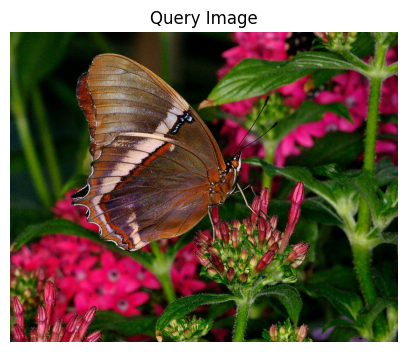

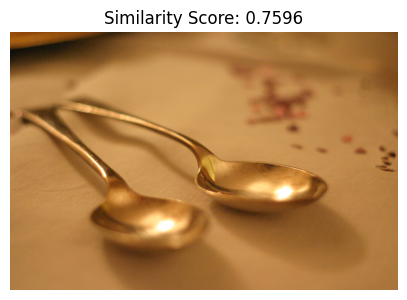

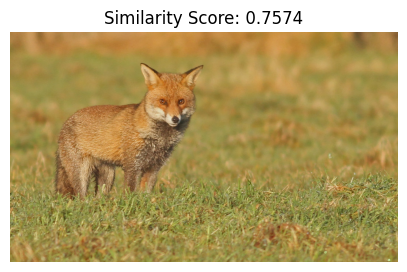

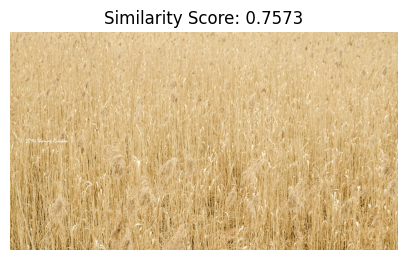

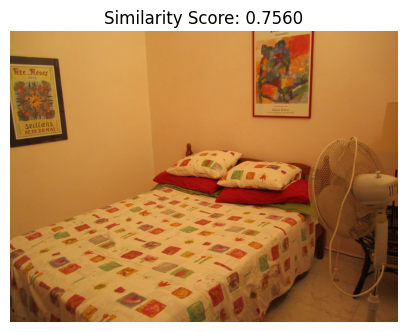

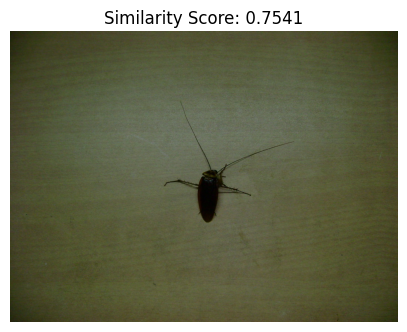

In [ ]:
# Define the root path and classes
ROOT = '/content/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

# Example usage
size = (448, 448)  # Define the size for image resizing
root_img_path = f'{ROOT}/train'
# Replace with the actual path to your query image
query_path = '/content/data/test/Butterfly/10407650646_9138c1349a_b.jpg'

# Compute cosine similarity scores
results = get_cosine_similarity_score(root_img_path, query_path, size)

# Sort results by similarity score in descending order
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

query_image = Image.open(query_path)
plt.figure(figsize=(5, 5))
plt.imshow(query_image)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 5 similar images with their scores
for image_path, score in results_sorted[:5]:
    image = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title(f"Similarity Score: {score:.4f}")
    plt.axis('off')
    plt.show()

# **Using pre-trained deep learning models for image searching.**

In [ ]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []

    for folder in os.listdir(root_img_path):
        folder_path = os.path.join(root_img_path, folder)
        if folder in CLASS_NAME and os.path.isdir(folder_path):
            images_np, images_path = folder_to_images(folder_path, size)  # Load numpy arrays of images and their paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)

            # Calculate cosine similarity
            rates = cosine_similarity(query_embedding.reshape(1, -1), np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates.flatten())))  # Flatten rates to avoid dimension issues

    return query, ls_path_score




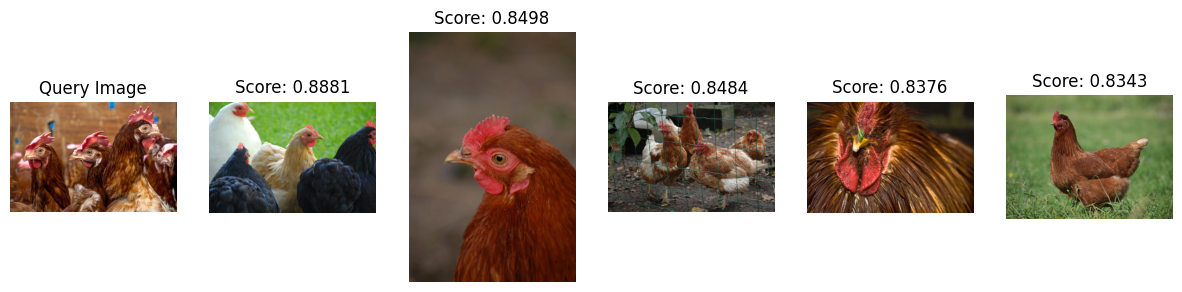

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_results(query_path, ls_path_score, reverse=False, top_n=5):
    # Sort the list ls_path_score by score
    ls_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)

    # Get the top N results
    ls_path_score = ls_path_score[:top_n]

    # Number of images to display
    num_images = len(ls_path_score)

    # Show query image
    query_img = Image.open(query_path).convert('RGB')

    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Display the images with the highest scores
    for i, (img_path, score) in enumerate(ls_path_score):
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, num_images + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {score:.4f}")
        plt.axis('off')

    plt.show()
root_img_path = f"{ROOT}/train/"
query_path = "/content/data/test/Chicken/13610947075_f376cfe5e2_b.jpg"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True) # Call the newly defined plot_results function

# **Improving image search using CLIP models and vector databases.**

In [ ]:
import os
import numpy as np
from PIL import Image
import chromadb
from tqdm import tqdm

# Constants
ROOT = '/content/data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))
HNSW_SPACE = "hnsw:space"

# Initialize Chroma client and collection
chroma_client = chromadb.Client()
cosine_collection = chroma_client.get_or_create_collection(name="Cosine_collection", metadata={HNSW_SPACE: "cosine"})

# Function to retrieve file paths from directories
def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = os.path.join(path, label)
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = os.path.join(label_path, filename)
            files_path.append(filepath)
    return files_path

# Function to preprocess image and convert it to a NumPy array
def preprocess_image(filepath):
    image = Image.open(filepath).convert('RGB')
    return np.array(image)  # Convert image to a NumPy array

# Function to convert a NumPy array to a list
def numpy_to_list(array):
    return array.tolist()

# Function to add embeddings to the collection
def add_embedding(collection, files_path):
    ids = []
    embeddings = []
    for id_filepath, filepath in tqdm(enumerate(files_path)):
        ids.append(f'id_{id_filepath}')
        image_array = preprocess_image(filepath)  # Preprocess and convert to array
        embedding = get_single_image_embedding(image_array)  # Generate embedding from array
        embedding_list = numpy_to_list(embedding)  # Convert NumPy array to list
        embeddings.append(embedding_list)
    collection.add(embeddings=embeddings, ids=ids)  # Add embeddings and IDs to the collection

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)
add_embedding(collection=cosine_collection, files_path=files_path)




2451it [11:56,  3.42it/s]


In [ ]:
def search(image_path, collection, n_results):
  query_image = Image.open(image_path).convert('RGB')  # Convert to RGB format
  query_image = np.array(query_image) # Convert to NumPy array
  query_embedding = get_single_image_embedding(query_image)
  # Convert NumPy array to list
  query_embedding_list = query_embedding.tolist()
  results = collection.query(
    query_embeddings=[query_embedding_list], # Pass a list of lists
    n_results=n_results
  )
  return results


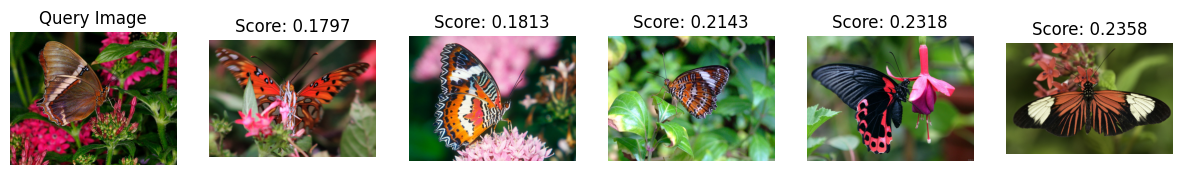

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_results(query_path, ls_path_score, files_path, reverse=False, top_n=5): # Added files_path
    # Sort the list ls_path_score by score
    ls_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)

    # Get the top N results
    ls_path_score = ls_path_score[:top_n]

    # Number of images to display
    num_images = len(ls_path_score)

    # Show query image
    query_img = Image.open(query_path).convert('RGB')

    plt.figure(figsize=(15, 5))
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Hiển thị các ảnh có điểm số cao nhất
    for i, (img_id, score) in enumerate(ls_path_score): # Iterate over (img_id, score)
        # Find the actual file path corresponding to the ID
        img_path = files_path[int(img_id.split('_')[1])] # Extract index from img_id
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, num_images + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Score: {score:.4f}")
        plt.axis('off')

    plt.show()


test_path = f'{ROOT}/test'
new_query_img_path = '/content/data/test/Butterfly/10407650646_9138c1349a_b.jpg'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
cosine_results = search(image_path=new_query_img_path, collection=cosine_collection, n_results=5)

# Create a list of tuples (image_path, score) from the search results
ls_path_score = list(zip(cosine_results['ids'][0], cosine_results['distances'][0]))
# Call plot_results with the correct ls_path_score format and files_path
plot_results(query_path=new_query_img_path, ls_path_score=ls_path_score, files_path=files_path)  # Pass files_path

# **Optimizing image search using CLIP models and vector databases by using FAISS library.**

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 36.8 MB/s eta 0:00:00


In [ ]:
import torch
import faiss
import numpy as np
from PIL import Image
from torchvision import transforms
from transformers import CLIPModel, CLIPProcessor
import os

# Initialize CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to create embedding for an image
def compute_embedding(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        embedding = model.get_image_features(**inputs).cpu().numpy()
    return embedding / np.linalg.norm(embedding)

# Calculate embeddings for all images and store in FAISS
image_dir = '/content/data/train'  # Path to the directory containing images

# Get a list of all image files in the directory, including subdirectories
image_paths = []
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
            image_paths.append(os.path.join(root, file))

# Calculate embeddings for all images
embeddings = np.vstack([compute_embedding(img_path) for img_path in image_paths])



In [ ]:
dimension = embeddings.shape[1]  # Number of dimensions of the embedding
index = faiss.IndexFlatIP(dimension)  # Use cosine similarity

index.add(embeddings)
faiss.write_index(index, 'image_embeddings_cosine.index')

In [ ]:
# Calculate embedding for the query image
query_image_path = '/content/data/test/Butterfly/10407650646_9138c1349a_b.jpg'
query_embedding = compute_embedding(query_image_path)

# Load FAISS index from file
index = faiss.read_index('image_embeddings_cosine.index')

# Perform search
k = 5  # Number of results to find
distances, indices = index.search(query_embedding, k)

# Display the results
for i in range(k): # Iterate over the top k results
    idx = indices[0][i] # Get the index from the search results
    img_path = image_paths[idx]
    img = Image.open(img_path)
    print(f"Distance: {distances[0][i]}") # Access the corresponding distance

Distance: 0.9193434715270996
Distance: 0.906673789024353
Distance: 0.9049364328384399
Distance: 0.9048194885253906
Distance: 0.9020076990127563


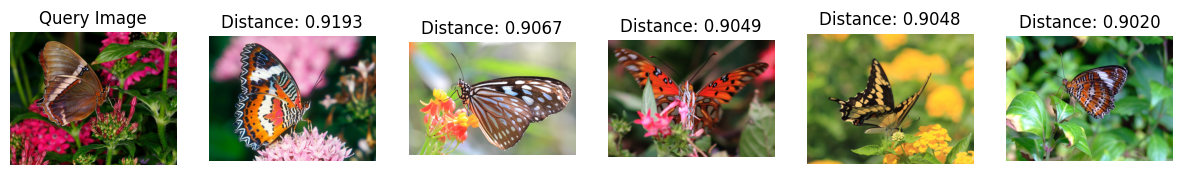

In [ ]:
import matplotlib.pyplot as plt

def plot_results(query_path, indices, distances, image_paths):
    # Show query image
    query_img = Image.open(query_path).convert('RGB')
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(indices) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Show the most similar results
    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        plt.subplot(1, len(indices) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Distance: {distances[i]:.4f}")
        plt.axis('off')

    plt.show()

plot_results(query_path=query_image_path, indices=indices[0], distances=distances[0], image_paths=image_paths)
